# Telecom Churn Prediction Case Study

**Authors:** Abhishek Mukherjee , Vaibhav Singh Chauhan

# Content
- Problem Statement
- Loading Datasets and Libraries
- Create X, y and then Train test split
- Handling Missing Value and Duplicated data
- Exploratory Data Analysis & Preprocessing
- Feature Engineering and Selection
- Model Building and Evaluation
- Test Data Preparation
- Unseen Data Preparation and Submission to Kaggle
- Conclusion

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, we are expected analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, our goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*



# 1. Loading Datasets and Libraries

Lets start by loading required libraries. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

#pip install missingno
import missingno as msno

# For MICE Imputation
#!pip install fancyimpute
from fancyimpute import IterativeImputer

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Class Imbalance handling
from imblearn.over_sampling import SMOTE

#XGboost
from xgboost import XGBClassifier

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, we will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that we are working with, which will help in analyzing which features might impact the churn rate of a user, and what sort of analysis could be done to understand the distribution of the feature better.

In [3]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [4]:
# Setting the maximum columns and rows display
pd.set_option("display.max_columns",300)
pd.set_option("display.max_rows",500)

In [5]:
# Lets see the train data
data.head() 

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [6]:
# Set index as id
data = data.set_index('id')
data.head()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                              
0         109             0.0             0.0             0.0   
1         109             0.0             0.0             0.0   
2         109             0.0             0.0             0.0   
3         109             0.0             0.0             0.0   
4         109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                           
0             6/30/2014            7/31/2014            8/31/2014   31.277   
1             6/30/2014            7/31/2014            8/31/2014    0.000   
2             6/30/2014            7/31/2014            8/31/2014   60.806   
3             6/30/2014            7/31/2014            8/31/2014  156.362   
4             6/30/2014            7/31/2014            8/31/2014  240.708   

     arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
id                                                                          
0    87.009    7.527        48.58       124.38         1.29         32.24   
1   122.787   42.953         0.00         0.00         0.00          0.00   
2   103.176    0.000         0.53        15.93         0.00         53.99   
3   205.260  111.095         7.26        16.01         0.00         68.76   
4   128.191  101.565        21.28         4.83         6.13         56.99   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                            
0          96.68          2.33           0.00            0.0            0.0   
1          25.99         30.89           0.00            0.0            0.0   
2          82.05          0.00           0.00            0.0            0.0   
3          78.48         50.23           0.00            0.0            0.0   
4          38.11          9.63          53.64            0.0            0.0   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                  
0            0.00            0.0           0.00              2.23   
1            0.00            0.0           0.00              0.00   
2            0.00            0.0           0.00              0.53   
3            0.00            0.0           1.63              6.99   
4           15.73            0.0           0.00             10.16   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                           
0               0.00              0.28              5.29             16.04   
1               0.00              0.00              0.00              0.00   
2              12.98              0.00             24.11              0.00   
3               3.94              0.00             37.91             44.89   
4               4.83              6.13             36.74             19.88   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                           
0               2.33              0.00              0.00              0.00   
1               0.00              0.00              0.00              0.00   
2               0.00              0.00              0.00              0.00   
3              23.63              0.00              0.00              0.00   
4               4.61             11.99              1.23              5.01   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                       
0               0.00              0.00              0.00          7.53   
1               0.00             22.01             29.79          0.00   
2               2.14             

In [7]:
# Lets get information on the dataset
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    circle_id                 int64  
 1    loc_og_t2o_mou            float64
 2    std_og_t2o_mou            float64
 3    loc_ic_t2o_mou            float64
 4    last_date_of_month_6      object 
 5    last_date_of_month_7      object 
 6    last_date_of_month_8      object 
 7    arpu_6                    float64
 8    arpu_7                    float64
 9    arpu_8                    float64
 10   onnet_mou_6               float64
 11   onnet_mou_7               float64
 12   onnet_mou_8               float64
 13   offnet_mou_6              float64
 14   offnet_mou_7              float64
 15   offnet_mou_8              float64
 16   roam_ic_mou_6             float64
 17   roam_ic_mou_7             float64
 18   roam_ic_mou_8             float64
 19   roam_og_mou_6             float64
 20   roam_og_m

In [8]:
# Lets get some summary statistics with some basic outliers analysis
# Including data at various percentiles as well
data.describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count    69999.0         69297.0         69297.0         69297.0   
mean       109.0             0.0             0.0             0.0   
std          0.0             0.0             0.0             0.0   
min        109.0             0.0             0.0             0.0   
25%        109.0             0.0             0.0             0.0   
50%        109.0             0.0             0.0             0.0   
75%        109.0             0.0             0.0             0.0   
90%        109.0             0.0             0.0             0.0   
95%        109.0             0.0             0.0             0.0   
99%        109.0             0.0             0.0             0.0   
max        109.0             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  67231.000000  67312.000000   
mean     283.134365    278.185912    278.858826    133.153275    133.894438   
std      334.213918    344.366927    351.924315    299.963093    311.277193   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.581000     86.714000     84.095000      7.410000      6.675000   
50%      197.484000    191.588000    192.234000     34.110000     32.280000   
75%      370.791000    365.369500    369.909000    119.390000    115.837500   
90%      619.993800    615.661400    614.994600    345.080000    347.908000   
95%      832.022700    823.236700    828.464700    617.185000    628.437500   
99%     1400.276640   1414.891380   1445.054800   1447.098000   1478.540900   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  66296.000000  67231.000000  67312.000000  66296.000000   67231.000000   
mean     132.978257    198.874771    197.153383    196.543577       9.765435   
std      311.896596    316.818355    322.482226    324.089234      57.374429   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        6.410000     34.860000     32.240000     31.575000       0.000000   
50%       32.100000     96.480000     91.885000     91.800000       0.000000   
75%      115.060000    232.990000    227.630000    229.345000       0.000000   
90%      343.695000    482.030000    482.071000    486.980000      11.950000   
95%      620.240000    735.985000    747.558000    738.017500      41.350000   
99%     1472.480500   1546.471000   1545.104000   1522.474000     219.649000   
max    10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   67312.000000   66296.000000   67231.000000   67312.000000   
mean        7.014568       7.004892      14.186457       9.842191   
std        55.960985      53.408135      73.469261      58.511894   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         5.039000       5.210000      22.710000       9.900000   
95%        23.199000      23.990000      69.455000      42.599000   
99%       153.006700     159.714000     290.851000     221.866800   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   66296.000000      67231.000000      67312.000000      66296.000000   
mean        9.771783         46.904854         46.166503         45.686109   
std        64.618388        150.971758        154.739002        153.716880   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.660000          1.650000     

There seems to be outliers in the numerical data, so we need to remove them for model building stage (some models may be influenced by outliers and we don't want that to happen)

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [9]:
data['circle_id'].unique()

array([109])

In [10]:
# Create the X, y data

X = data.drop(['circle_id'], axis=1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 169), (69999,))

**Splitting train and test data to avoid any contamination of the test data**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 169), (14000, 169), (55999,), (14000,))

In [12]:
X_train.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
id                                                                           
44070             0.0             0.0             0.0            6/30/2014   
356               0.0             0.0             0.0            6/30/2014   
43850             0.0             0.0             0.0            6/30/2014   
60953             0.0             0.0             0.0            6/30/2014   
45444             0.0             0.0             0.0            6/30/2014   

      last_date_of_month_7 last_date_of_month_8   arpu_6    arpu_7    arpu_8  \
id                                                                             
44070            7/31/2014            8/31/2014  425.240   312.117   421.019   
356              7/31/2014            8/31/2014  375.797     3.530    95.851   
43850            7/31/2014            8/31/2014   77.199    52.447    44.428   
60953            7/31/2014            8/31/2014  952.941  1496.601  1384.928   
45444            7/31/2014            8/31/2014   80.684    50.925    16.434   

       onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                         
44070       126.44        51.83        30.14        144.06         81.64   
356           1.14         0.00         0.21        200.04          1.36   
43850        12.46         2.08         5.26         30.91         25.24   
60953      1823.04      2874.78      3259.18         75.71        136.23   
45444        10.14        11.49         9.33         25.54         17.73   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                 
44070        110.08           0.00           0.00           0.00   
356           63.43          34.93           6.63           0.51   
43850         13.89           0.00           0.00           0.00   
60953         49.24           0.00           0.00           0.00   
45444         17.69           0.00           0.00           0.00   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                     
44070           0.00           0.00            0.0            126.44   
356           156.26           1.36            0.0              0.68   
43850           0.00           0.00            0.0             12.46   
60953           0.61           0.00            0.0             23.54   
45444           0.00           0.00            0.0              1.06   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                              
44070             51.83             30.14            143.04             81.64   
356                0.00              0.21              5.74              0.00   
43850              2.08              5.26             22.54             19.74   
60953              6.23             26.48             22.86             24.48   
45444              1.49              1.53             25.54             12.99   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                              
44070            103.86              1.01              0.00              6.21   
356               25.89              0.00              0.00              0.00   
43850              4.79              8.36              5.49              9.09   
60953             24.33              0.00              3.09              4.41   
45444             17.69              0.00              0.00              0.00   

       loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                          
44070              0.00              0.00              0.00        270.51   
356              

# 3. Handling Missing & Duplicate Data

We will be imputing missing data approach only in X_train dataset and the imputed values learned from X_train dataset will be later applied to X_test dataset. This is an approach to help avoid contamination

<Axes: >

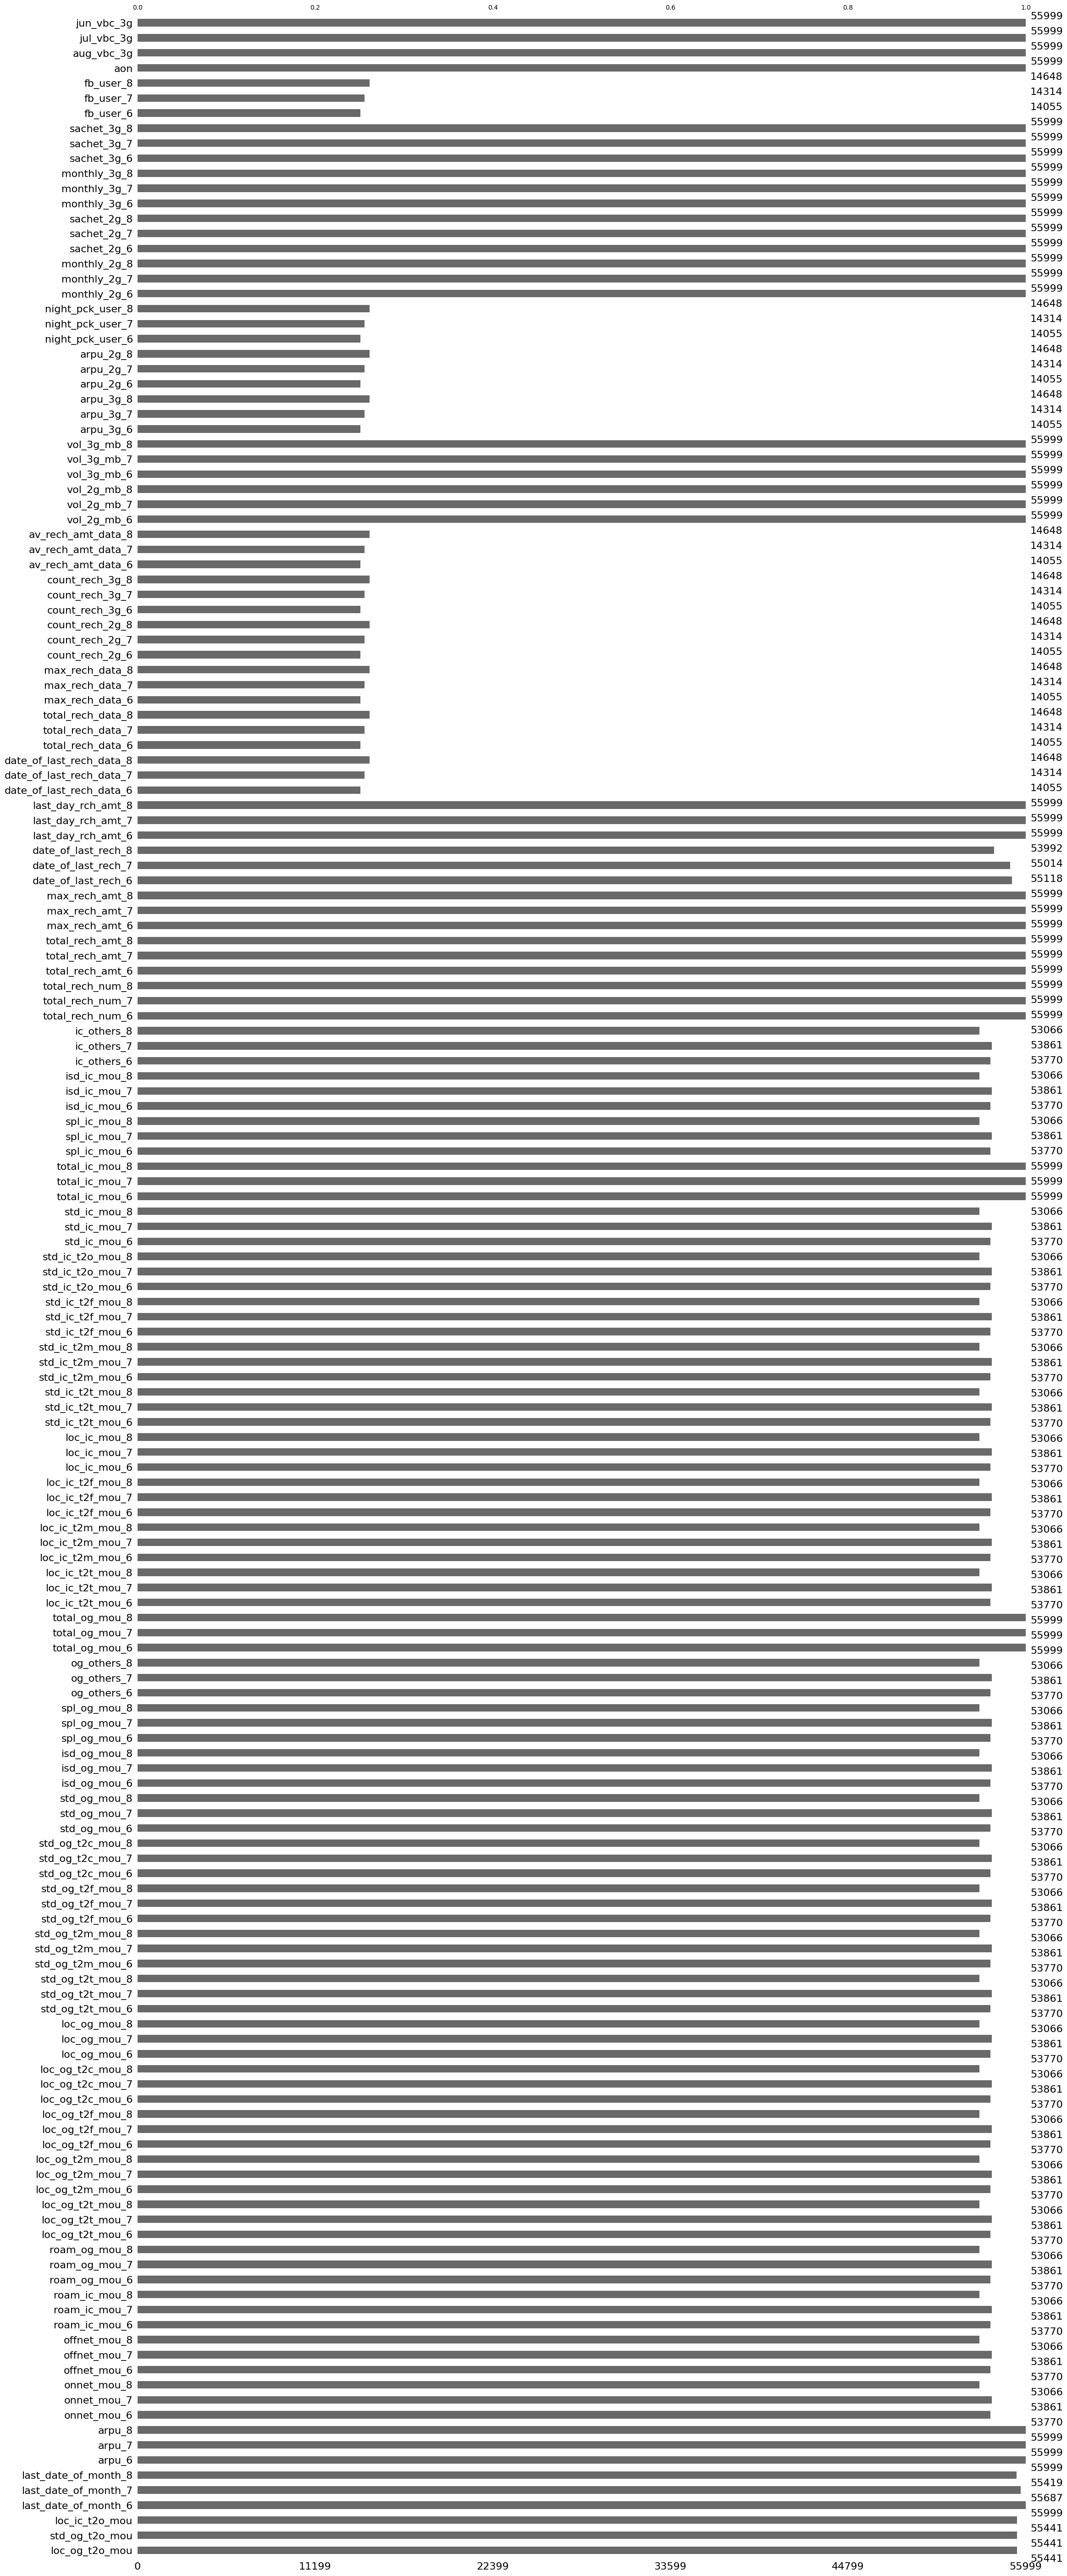

In [13]:
#Visualizing missing data in the dataset
msno.bar(X_train)

<Axes: >

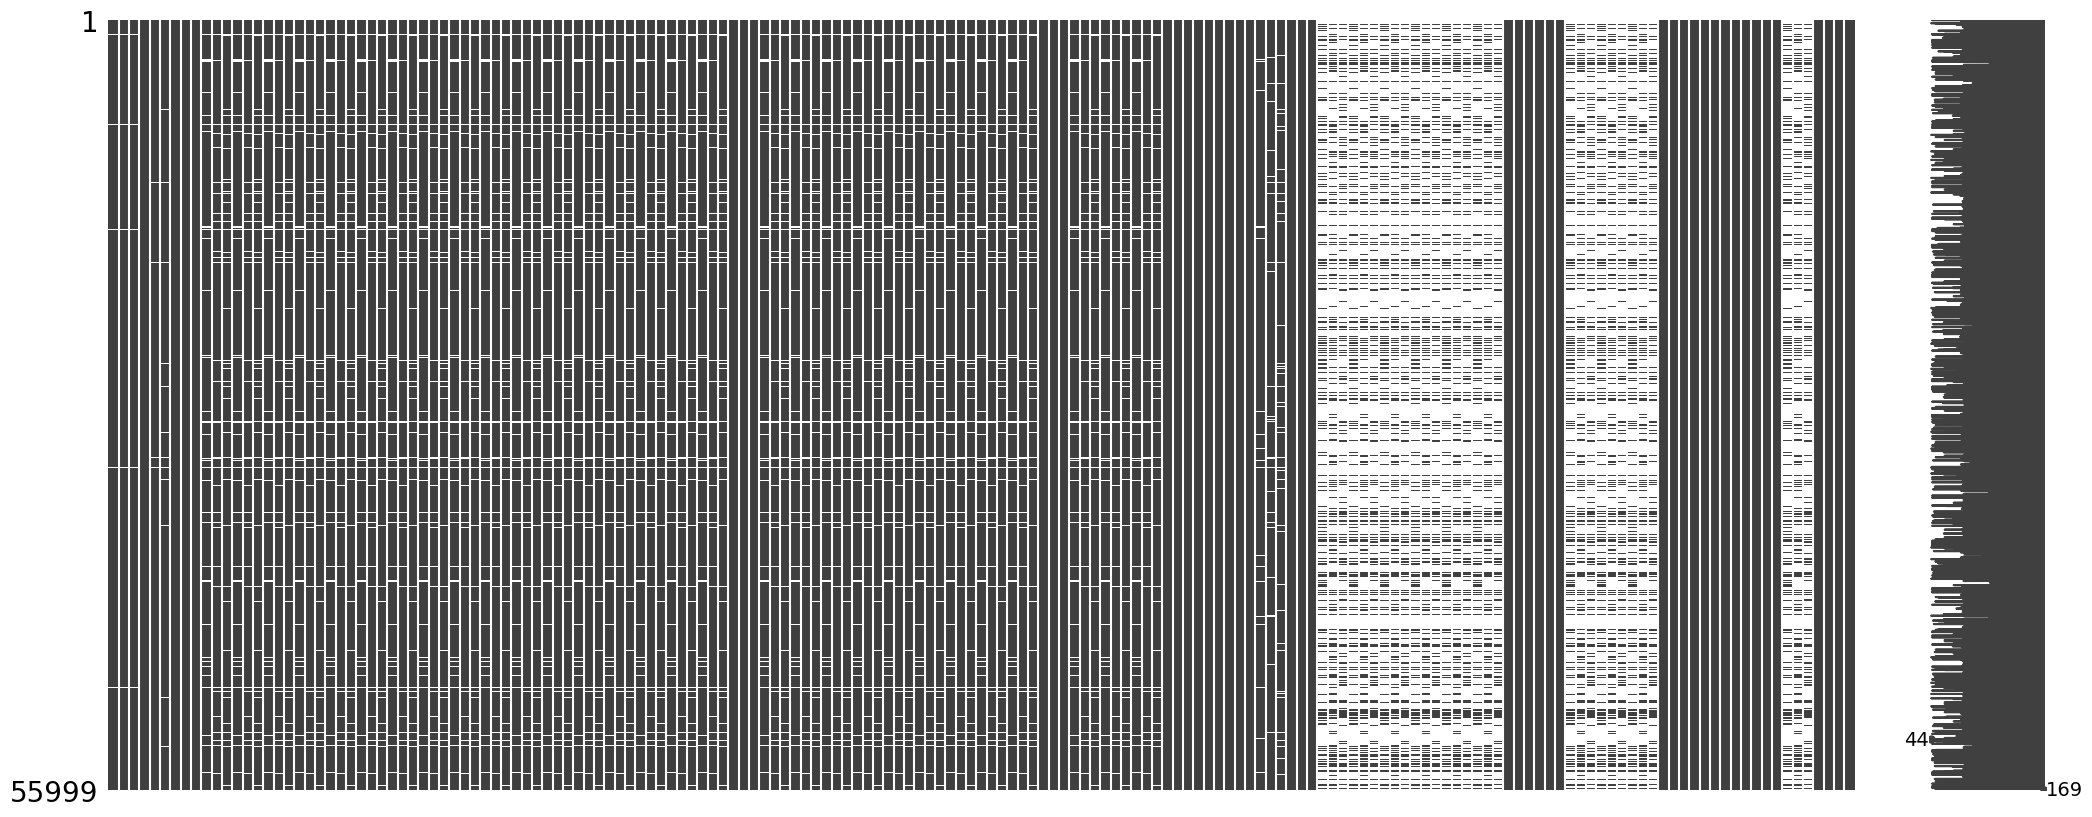

In [14]:
msno.matrix(X_train)

Looks like there are some clusters of missing data

In [15]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent.sort_values(ascending=False)

date_of_last_rech_data_6    74.901338
count_rech_3g_6             74.901338
arpu_3g_6                   74.901338
av_rech_amt_data_6          74.901338
fb_user_6                   74.901338
night_pck_user_6            74.901338
arpu_2g_6                   74.901338
count_rech_2g_6             74.901338
max_rech_data_6             74.901338
total_rech_data_6           74.901338
arpu_3g_7                   74.438829
max_rech_data_7             74.438829
total_rech_data_7           74.438829
count_rech_3g_7             74.438829
av_rech_amt_data_7          74.438829
arpu_2g_7                   74.438829
night_pck_user_7            74.438829
fb_user_7                   74.438829
count_rech_2g_7             74.438829
date_of_last_rech_data_7    74.438829
av_rech_amt_data_8          73.842390
total_rech_data_8           73.842390
max_rech_data_8             73.842390
count_rech_3g_8             73.842390
count_rech_2g_8             73.842390
arpu_3g_8                   73.842390
date_of_last

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 30% missing data.

In [16]:
new_vars = missing_data_percent[missing_data_percent.le(30)].index
new_vars

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=139)

In [17]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 139)

Lets check the missing values again

In [18]:
missing_data_percent = 100*X_train_filtered.isnull().sum()/len(y_train)
missing_data_percent.sort_values(ascending=False)

spl_ic_mou_8            5.237594
isd_ic_mou_8            5.237594
std_ic_t2m_mou_8        5.237594
std_ic_t2t_mou_8        5.237594
loc_ic_mou_8            5.237594
loc_ic_t2f_mou_8        5.237594
loc_og_t2t_mou_8        5.237594
loc_og_t2m_mou_8        5.237594
roam_og_mou_8           5.237594
roam_ic_mou_8           5.237594
loc_og_t2c_mou_8        5.237594
loc_og_t2f_mou_8        5.237594
loc_ic_t2m_mou_8        5.237594
std_ic_t2f_mou_8        5.237594
onnet_mou_8             5.237594
offnet_mou_8            5.237594
ic_others_8             5.237594
std_ic_mou_8            5.237594
std_og_t2c_mou_8        5.237594
spl_og_mou_8            5.237594
loc_ic_t2t_mou_8        5.237594
og_others_8             5.237594
std_og_t2m_mou_8        5.237594
std_og_t2f_mou_8        5.237594
std_og_t2t_mou_8        5.237594
loc_og_mou_8            5.237594
isd_og_mou_8            5.237594
std_ic_t2o_mou_8        5.237594
std_og_mou_8            5.237594
loc_ic_mou_6            3.980428
loc_og_t2t

In [19]:
# Lets also find features which have constant values
nonunique_features = [feature for feature in X_train_filtered.columns if X_train_filtered[feature].nunique() == 1]
len(nonunique_features)

12

In [20]:
# Lets see those features
X_train_filtered[nonunique_features].head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
id                                                                           
44070             0.0             0.0             0.0            6/30/2014   
356               0.0             0.0             0.0            6/30/2014   
43850             0.0             0.0             0.0            6/30/2014   
60953             0.0             0.0             0.0            6/30/2014   
45444             0.0             0.0             0.0            6/30/2014   

      last_date_of_month_7 last_date_of_month_8  std_og_t2c_mou_6  \
id                                                                  
44070            7/31/2014            8/31/2014               0.0   
356              7/31/2014            8/31/2014               0.0   
43850            7/31/2014            8/31/2014               0.0   
60953            7/31/2014            8/31/2014               0.0   
45444            7/31/2014            8/31/2014               0.0   

       std_og_t2c_mou_7  std_og_t2c_mou_8  std_ic_t2o_mou_6  std_ic_t2o_mou_7  \
id                                                                              
44070               0.0               0.0               0.0               0.0   
356                 0.0               0.0               0.0               0.0   
43850               0.0               0.0               0.0               0.0   
60953               0.0               0.0               0.0               0.0   
45444               0.0               0.0               0.0               0.0   

       std_ic_t2o_mou_8  
id                       
44070               0.0  
356                 0.0  
43850               0.0  
60953               0.0  
45444               0.0

In [21]:
# Lets drop these features

X_train_filtered.drop(nonunique_features, axis=1, inplace=True)

In [22]:
# Check missing values again
missing_data_percent = 100*X_train_filtered.isnull().sum()/len(y_train)
missing_data_percent.sort_values(ascending=False)

ic_others_8            5.237594
offnet_mou_8           5.237594
roam_ic_mou_8          5.237594
roam_og_mou_8          5.237594
isd_ic_mou_8           5.237594
spl_ic_mou_8           5.237594
loc_og_t2c_mou_8       5.237594
loc_og_mou_8           5.237594
loc_og_t2t_mou_8       5.237594
loc_og_t2m_mou_8       5.237594
loc_og_t2f_mou_8       5.237594
onnet_mou_8            5.237594
loc_ic_t2m_mou_8       5.237594
std_og_mou_8           5.237594
std_og_t2f_mou_8       5.237594
loc_ic_mou_8           5.237594
std_ic_t2m_mou_8       5.237594
std_ic_t2t_mou_8       5.237594
std_og_t2t_mou_8       5.237594
std_og_t2m_mou_8       5.237594
std_ic_mou_8           5.237594
std_ic_t2f_mou_8       5.237594
og_others_8            5.237594
loc_ic_t2t_mou_8       5.237594
spl_og_mou_8           5.237594
loc_ic_t2f_mou_8       5.237594
isd_og_mou_8           5.237594
std_og_t2t_mou_6       3.980428
loc_og_t2f_mou_6       3.980428
loc_og_mou_6           3.980428
loc_og_t2t_mou_6       3.980428
roam_og_

There are multiple ways to deal with missing values. Some of the quickest way is using the following strategy:

- For numerical columns use "Median"
- For categorical columns use "Mode"

We can also use an advanced Imputer called MICE (Multiple Imputation by Chained Equation). It is an advanced missing data imputation technique that uses multiple iterations of Machine Learning model training to predict the missing values using known values from other features in the data as predictors. There is a library called fancyimputer that implements this, but it is very computationally expensive so defaulting to simpler techniques

In [23]:
# Prior to that lets try to process "recharge columns"
#Impute columns related to recharge with 0
rech_cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8',
'max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8']
X_train_filtered[rech_cols] = X_train_filtered[rech_cols].apply(lambda x: x.fillna(0))

In [24]:
# Process date columns
date_cols = X_train_filtered.select_dtypes(include="object").columns
date_cols

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

These date columns could be useful for predicting churn, so lets try to derive the days from last recharge from a date beyound the dataset

In [25]:
date_of_last_rech = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [26]:
from datetime import date
date_beyond_dataset = date(2014, 9, 30)

In [27]:
# convert date_cols to datetime
# select max() date in date_cols and compute the diff with 'date_beyond_dataset' in days
# drop date_cols, add a new column with 'new_col_name' with a count of days
# df[date_cols].apply(pd.to_datetime)

def day_counts(df, date_cols, today, new_col_name):   
    df[new_col_name] = (pd.Timestamp(date_beyond_dataset) - df[date_cols].apply(pd.to_datetime).max(axis=1)).dt.days 
    df.drop(date_cols, axis=1, inplace=True)

In [28]:
day_counts(X_train_filtered, date_of_last_rech, date_beyond_dataset, 'days_from_last_recharge')

In [29]:
X_train_filtered[['days_from_last_recharge']].isnull().mean()

days_from_last_recharge    0.000911
dtype: float64

In [30]:
X_train_filtered[['days_from_last_recharge']] = X_train_filtered[['days_from_last_recharge']].fillna(-1)

In [31]:
# Check if all columns are numeric
X_train_filtered.dtypes 

arpu_6                     float64
arpu_7                     float64
arpu_8                     float64
onnet_mou_6                float64
onnet_mou_7                float64
onnet_mou_8                float64
offnet_mou_6               float64
offnet_mou_7               float64
offnet_mou_8               float64
roam_ic_mou_6              float64
roam_ic_mou_7              float64
roam_ic_mou_8              float64
roam_og_mou_6              float64
roam_og_mou_7              float64
roam_og_mou_8              float64
loc_og_t2t_mou_6           float64
loc_og_t2t_mou_7           float64
loc_og_t2t_mou_8           float64
loc_og_t2m_mou_6           float64
loc_og_t2m_mou_7           float64
loc_og_t2m_mou_8           float64
loc_og_t2f_mou_6           float64
loc_og_t2f_mou_7           float64
loc_og_t2f_mou_8           float64
loc_og_t2c_mou_6           float64
loc_og_t2c_mou_7           float64
loc_og_t2c_mou_8           float64
loc_og_mou_6               float64
loc_og_mou_7        

In [32]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [33]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

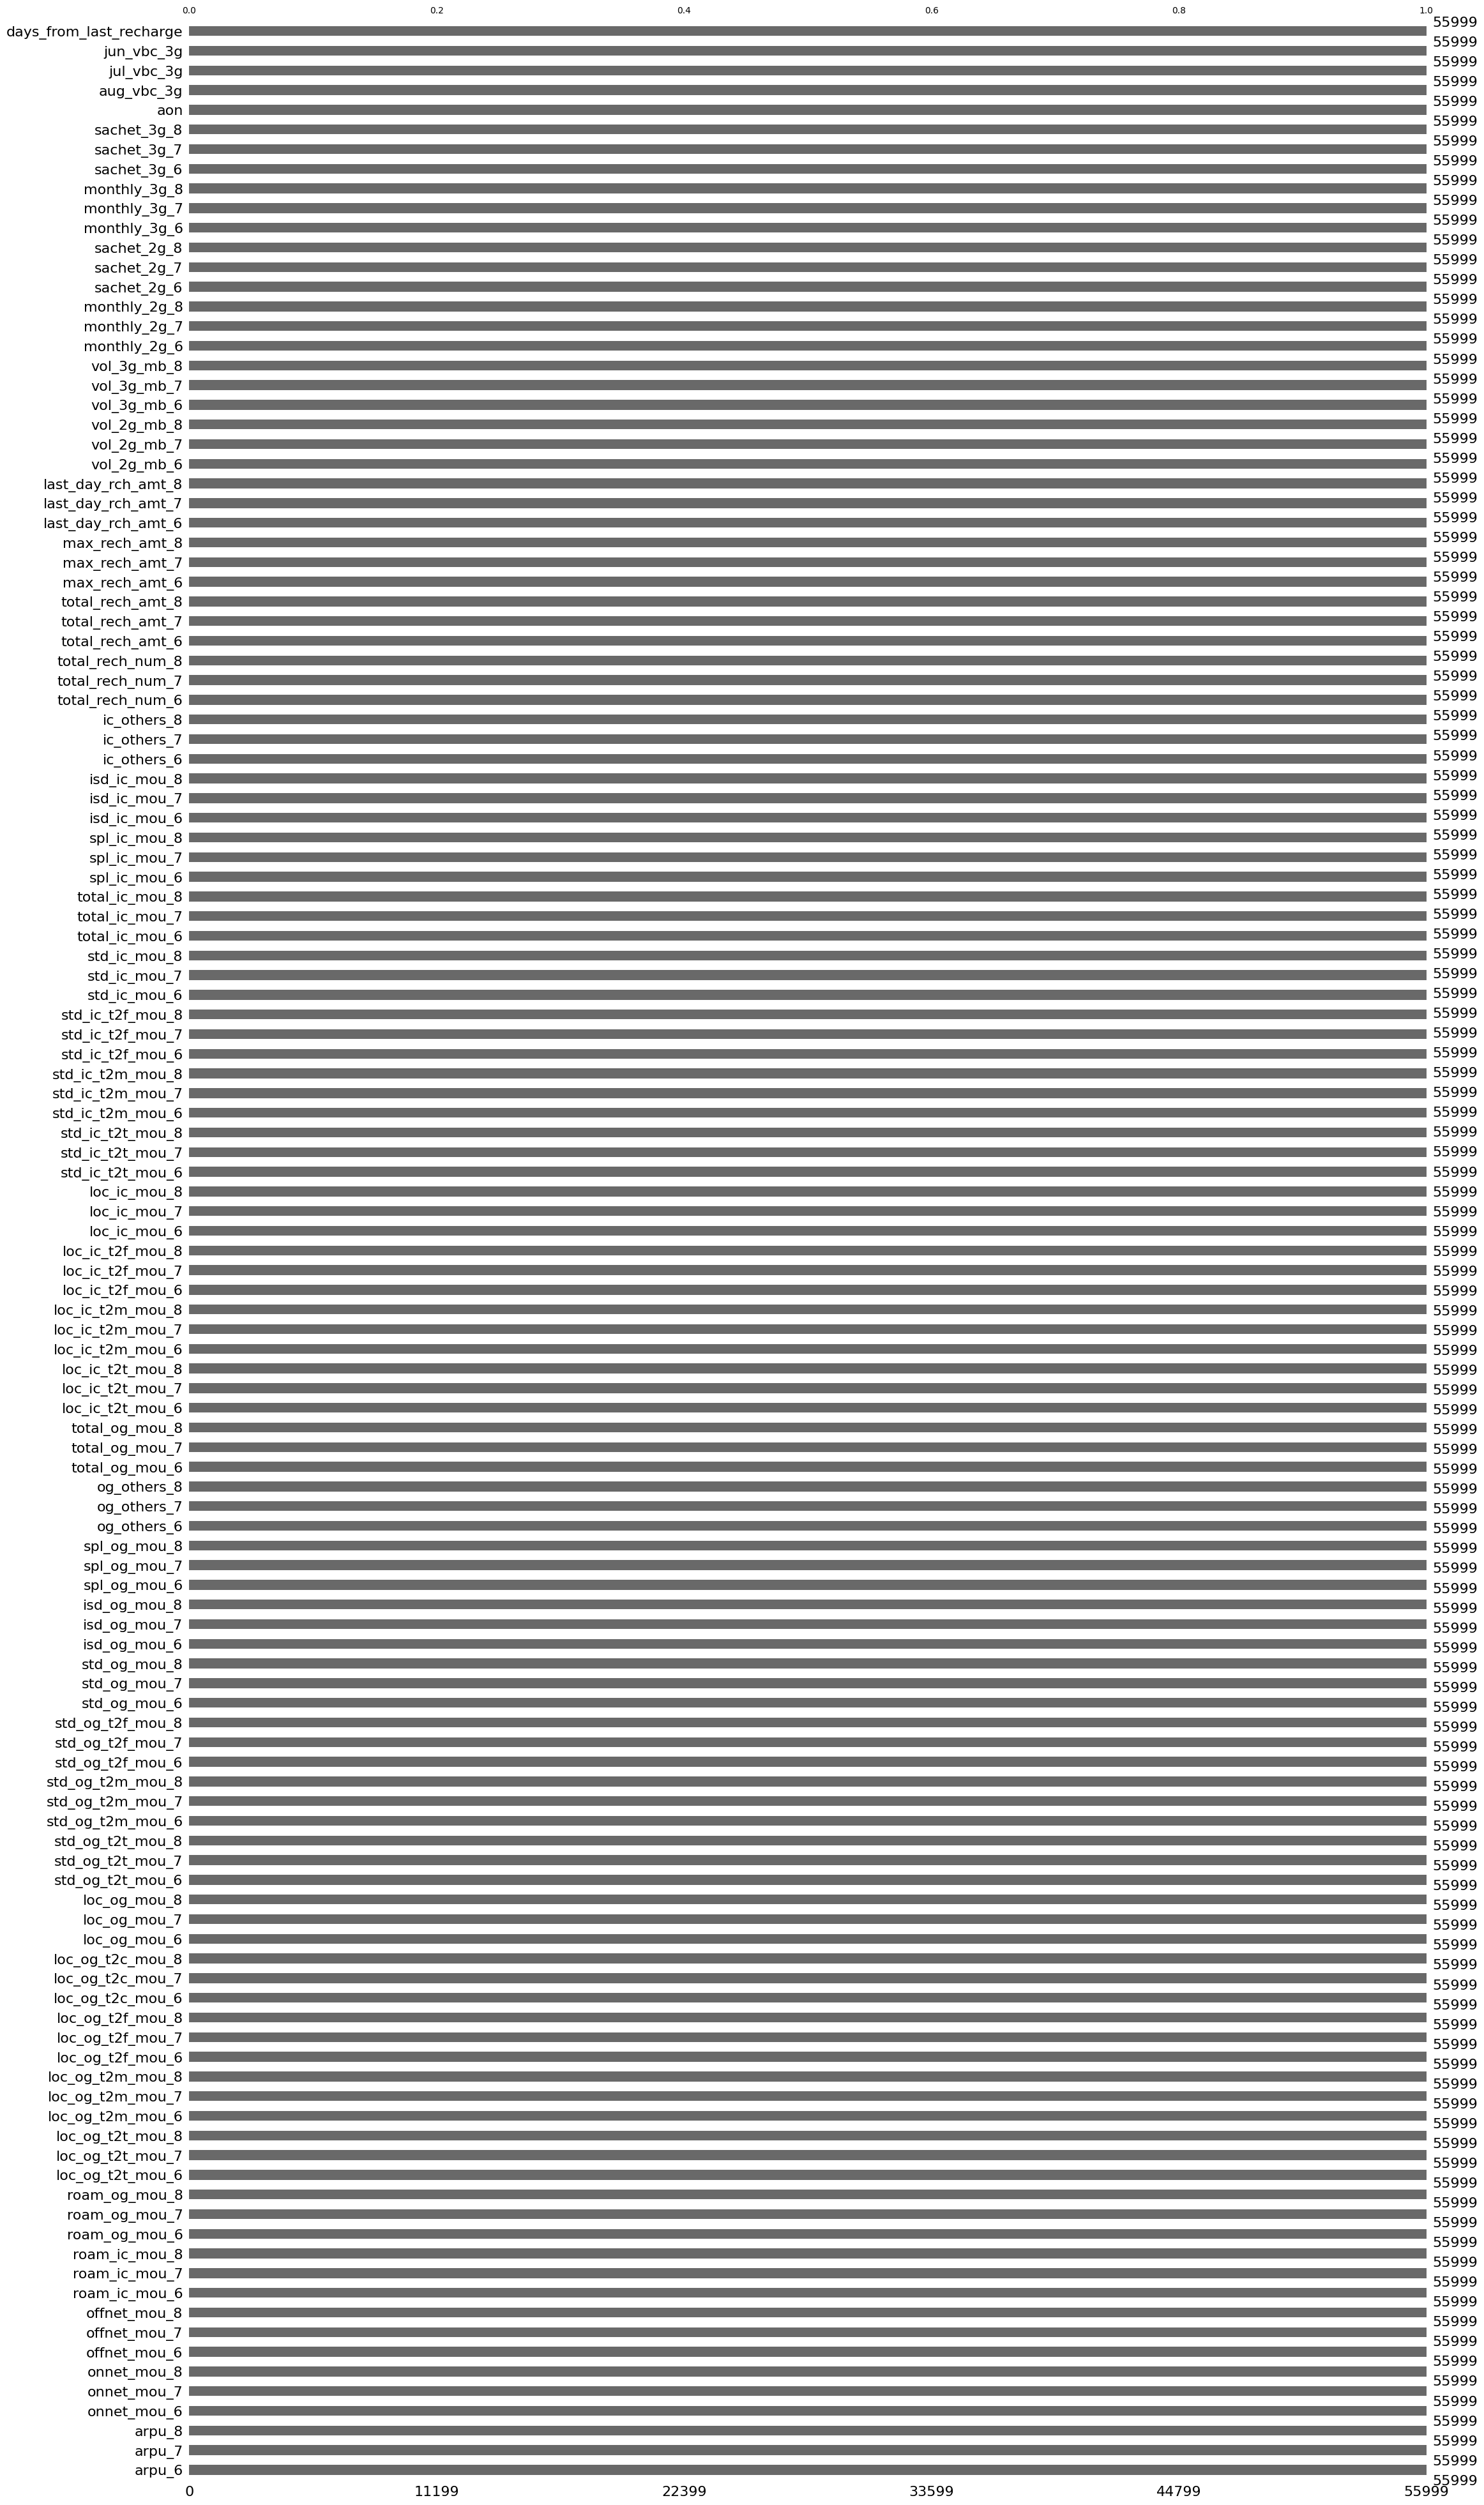

In [34]:
#Lets visualize missing data now
msno.bar(X_train_filtered)

In [35]:
X_train_filtered.isna().mean()

arpu_6                     0.0
arpu_7                     0.0
arpu_8                     0.0
onnet_mou_6                0.0
onnet_mou_7                0.0
onnet_mou_8                0.0
offnet_mou_6               0.0
offnet_mou_7               0.0
offnet_mou_8               0.0
roam_ic_mou_6              0.0
roam_ic_mou_7              0.0
roam_ic_mou_8              0.0
roam_og_mou_6              0.0
roam_og_mou_7              0.0
roam_og_mou_8              0.0
loc_og_t2t_mou_6           0.0
loc_og_t2t_mou_7           0.0
loc_og_t2t_mou_8           0.0
loc_og_t2m_mou_6           0.0
loc_og_t2m_mou_7           0.0
loc_og_t2m_mou_8           0.0
loc_og_t2f_mou_6           0.0
loc_og_t2f_mou_7           0.0
loc_og_t2f_mou_8           0.0
loc_og_t2c_mou_6           0.0
loc_og_t2c_mou_7           0.0
loc_og_t2c_mou_8           0.0
loc_og_mou_6               0.0
loc_og_mou_7               0.0
loc_og_mou_8               0.0
std_og_t2t_mou_6           0.0
std_og_t2t_mou_7           0.0
std_og_t

All the missing data has been handled

Lets check for duplicate data

In [36]:
X_train_filtered.duplicated().sum()

0

There are no duplicate data in the train set

# 4. Exploratory Data Analysis & Preprocessing

Lets process the numerical columns in terms of outliers and univariate/bivariate/multivariate analysis

In [37]:
# Since the number of columns are pretty high, doing nay univariate analysis of all these columns would be impossible. Lets use the describe function to analyze
X_train_filtered.describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

arpu_6        arpu_7        arpu_8   onnet_mou_6  onnet_mou_7  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.00000   
mean     282.566107    277.823535    278.429677    127.878672    128.85611   
std      341.083306    351.322459    350.992352    294.858965    305.53582   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.00000   
25%       93.495000     86.967500     84.373000      5.430000      4.88000   
50%      196.929000    191.630000    193.050000     30.690000     29.28000   
75%      369.943500    364.359500    369.556500    112.285000    108.86000   
90%      618.898000    614.499600    614.021000    333.116000    334.37000   
95%      831.871300    818.904900    827.234300    599.700000    613.68000   
99%     1393.977340   1402.808040   1436.617220   1429.060000   1455.15600   
max    27731.088000  35145.834000  33543.624000   7011.110000   8011.91000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000   55999.000000   
mean     125.959385    190.126536    188.902536    186.183713       9.366028   
std      302.637094    310.511781    316.714633    315.087980      56.369024   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        4.130000     28.740000     26.860000     23.860000       0.000000   
50%       27.780000     89.730000     85.740000     83.480000       0.000000   
75%      106.670000    221.685000    217.580000    216.360000       0.000000   
90%      328.810000    466.620000    466.612000    465.230000      10.832000   
95%      598.652000    718.283000    725.077000    717.200000      38.442000   
99%     1450.631200   1523.414800   1510.856800   1493.901600     215.183000   
max    10752.560000   6712.810000   7043.980000   7460.210000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   55999.000000   55999.000000   55999.000000   55999.000000   
mean        6.622817       6.579918      13.582670       9.337500   
std        53.147811      51.142347      71.838269      56.466769   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         4.292000       4.160000      20.714000       8.364000   
95%        20.881000      21.860000      65.680000      39.881000   
99%       145.938600     148.211400     282.282200     213.160000   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   55999.000000      55999.000000      55999.000000      55999.000000   
mean        9.272592         45.292273         44.532369         43.356933   
std        64.638142        152.162717        152.990412        151.436865   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.010000          1.030000          0.780000   
50%         0.000000         10.680000         10.410000         10.080000   
75%         0.000000         38.710000         37.910000         37.240000   
90%         7.560000        100.998000         98.310000         97.490000   
95%        38.890000        172.413000        169.640000        167.013000   
99%       204.161000        534.677400        520.789200        513.270000   
max      5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      55999.000000      55999.000000      55999.000000      55999.000000   
mean          89.026140         86.936267         86.324133          3.574722   
std          158.278467        150.995100        150.994482         12.983564   
min            0.000000  

From the above table it is pretty evident that there are lots of outliers in the data and next step we will remove these outliers

### 4.1 Handling outliers


These outliers can be capped with k-sigma method.


In [38]:
# Define a function to remove outliers

def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [39]:
X_train_filtered = X_train_filtered.apply(cap_outliers, axis=0)

In [40]:
# Lets check the dataframe again to check the summary statistics
X_train_filtered.describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     275.025503    270.382691    270.761341    114.639427    115.269744   
std      263.874880    264.928196    267.932715    208.723856    214.445971   
min     -740.683812   -776.143843   -774.547380      0.000000      0.000000   
25%       93.495000     86.967500     84.373000      5.430000      4.880000   
50%      196.929000    191.630000    193.050000     30.690000     29.280000   
75%      369.943500    364.359500    369.556500    112.285000    108.860000   
90%      618.898000    614.499600    614.021000    333.116000    334.370000   
95%      831.871300    818.904900    827.234300    599.700000    613.680000   
99%     1305.816025   1331.790913   1331.406734   1012.455568   1045.463570   
max     1305.816025   1331.790913   1331.406734   1012.455568   1045.463570   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000   55999.000000   
mean     112.537814    177.719928    176.433937    174.020141       6.774558   
std      210.850320    237.497268    240.721319    239.229822      26.302328   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        4.130000     28.740000     26.860000     23.860000       0.000000   
50%       27.780000     89.730000     85.740000     83.480000       0.000000   
75%      106.670000    221.685000    217.580000    216.360000       0.000000   
90%      328.810000    466.620000    466.612000    465.230000      10.832000   
95%      598.652000    718.283000    725.077000    717.200000      38.442000   
99%     1033.870666   1121.661880   1139.046436   1131.447651     178.473100   
max     1033.870666   1121.661880   1139.046436   1131.447651     178.473100   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   55999.000000   55999.000000   55999.000000   55999.000000   
mean        4.524966       4.472015      10.221877       6.658243   
std        20.681930      20.274022      36.489194      26.782077   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         4.292000       4.160000      20.714000       8.364000   
95%        20.881000      21.860000      65.680000      39.881000   
99%       145.938600     148.211400     229.097477     178.737806   
max       166.066250     160.006960     229.097477     178.737806   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   55999.000000      55999.000000      55999.000000      55999.000000   
mean        6.713446         38.750077         38.017961         37.340819   
std        28.045028         77.864389         77.070629         75.918970   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.010000          1.030000          0.780000   
50%         0.000000         10.680000         10.410000         10.080000   
75%         0.000000         38.710000         37.910000         37.240000   
90%         7.560000        100.998000         98.310000         97.490000   
95%        38.890000        172.413000        169.640000        167.013000   
99%       203.187017        501.780425        503.503604        497.667526   
max       203.187017        501.780425        503.503604        497.667526   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      55999.000000      55999.000000      55999.000000      55999.000000   
mean          82.917585         81.101270         80.572334          3.023436   
std          117.709270        114.280146        114.446690          7.556733   
min          

Lets also plot the correlations for each feature for bivariate analysis.

In [41]:
data_eda = pd.concat([X_train_filtered, y_train], axis=1)
data_eda.head()

arpu_6       arpu_7       arpu_8  onnet_mou_6  onnet_mou_7  \
id                                                                   
44070  425.240   312.117000   421.019000   126.440000     51.83000   
356    375.797     3.530000    95.851000     1.140000      0.00000   
43850   77.199    52.447000    44.428000    12.460000      2.08000   
60953  952.941  1331.790913  1331.406734  1012.455568   1045.46357   
45444   80.684    50.925000    16.434000    10.140000     11.49000   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
id                                                                            
44070    30.140000        144.06         81.64        110.08           0.00   
356       0.210000        200.04          1.36         63.43          34.93   
43850     5.260000         30.91         25.24         13.89           0.00   
60953  1033.870666         75.71        136.23         49.24           0.00   
45444     9.330000         25.54         17.73         17.69           0.00   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
id                                                                  
44070           0.00           0.00           0.00           0.00   
356             6.63           0.51         156.26           1.36   
43850           0.00           0.00           0.00           0.00   
60953           0.00           0.00           0.61           0.00   
45444           0.00           0.00           0.00           0.00   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
id                                                                           
44070            0.0            126.44             51.83             30.14   
356              0.0              0.68              0.00              0.21   
43850            0.0             12.46              2.08              5.26   
60953            0.0             23.54              6.23             26.48   
45444            0.0              1.06              1.49              1.53   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
id                                                                              
44070            143.04             81.64            103.86              1.01   
356                5.74              0.00             25.89              0.00   
43850             22.54             19.74              4.79              8.36   
60953             22.86             24.48             24.33              0.00   
45444             25.54             12.99             17.69              0.00   

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
id                                                                              
44070              0.00              6.21              0.00              0.00   
356                0.00              0.00              0.00              0.46   
43850              5.49              9.09              0.00              0.00   
60953              3.09              4.41              1.01              0.00   
45444              0.00              0.00              0.00              0.93   

       loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  \
id                                                                  
44070              0.00        270.51        133.48        140.23   
356                0.00          6.43          0.00         26.11   
43850              0.00         43.38         27.33         19.16   
60953             10.71         46.41         33.81         55.23   
45444              0.00         26.61         14.49         19.23   

       std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  \
id                                                                              
44070          0.000000          0.000000          0.000000              0.00   
356            0.000000          0.000000          0.000000          

There seems to be light correlation, Lets do a deep dive

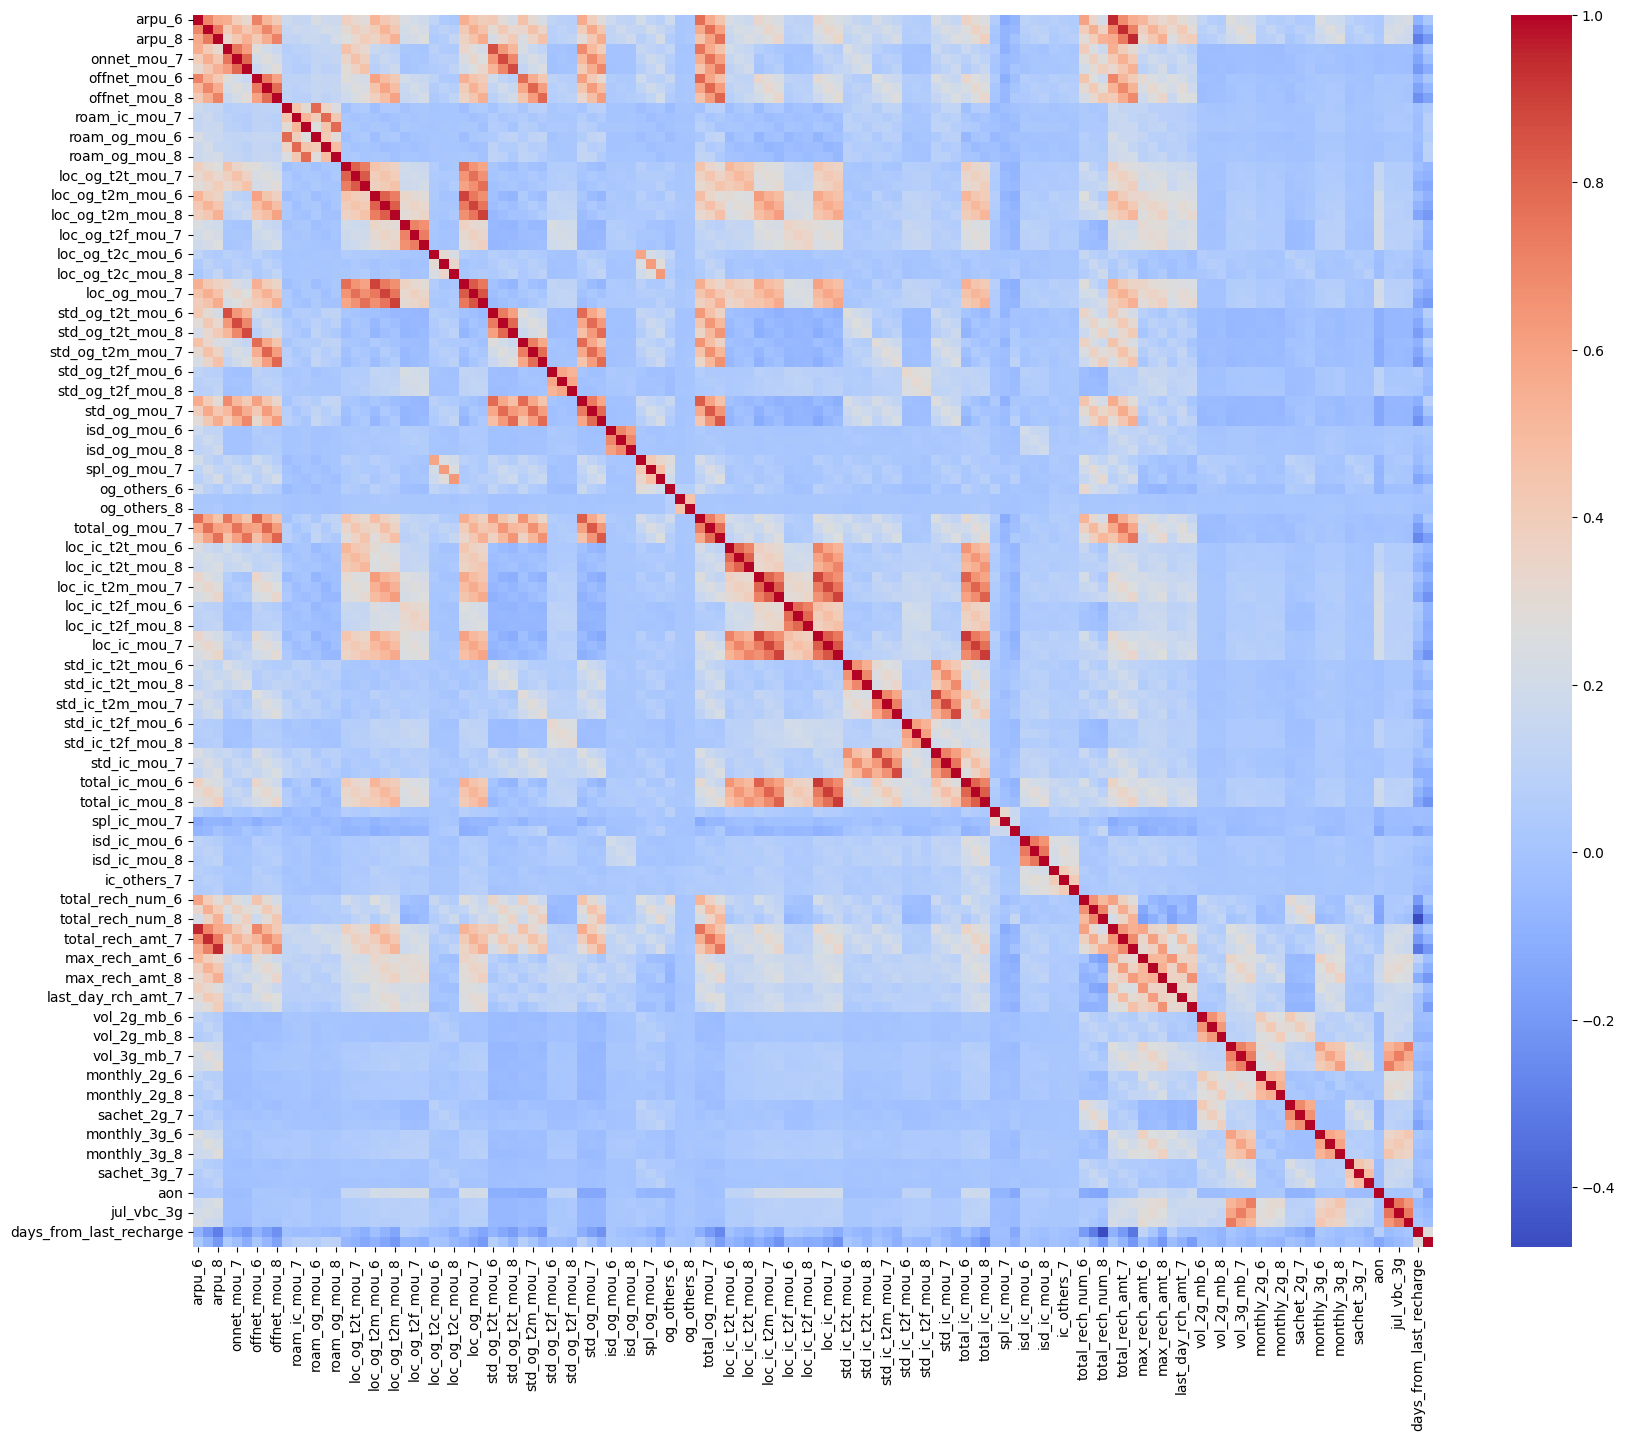

In [42]:
# Lets check the correlations of the numeric variables with each other and with "churn_probability"
plt.figure(figsize=(20, 16))
sns.heatmap(data_eda.corr(), cmap="coolwarm")
plt.show()

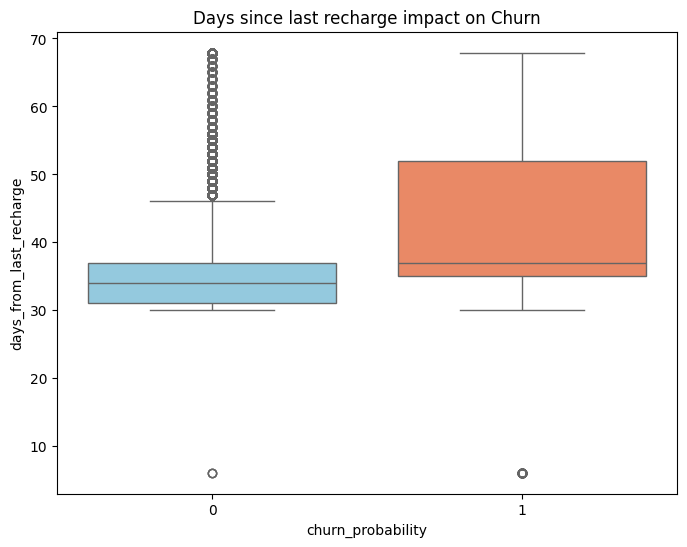

In [43]:
# Lets check the correlation between days from last recharge column we derived in last section and churn probability
plt.figure(figsize=[8, 6])
sns.boxplot(data=data_eda, x='churn_probability', y='days_from_last_recharge', palette=["skyblue", "coral"])
plt.title("Days since last recharge impact on Churn")
plt.show()

There seems to be higher churn for folks with higher number of days without recharge

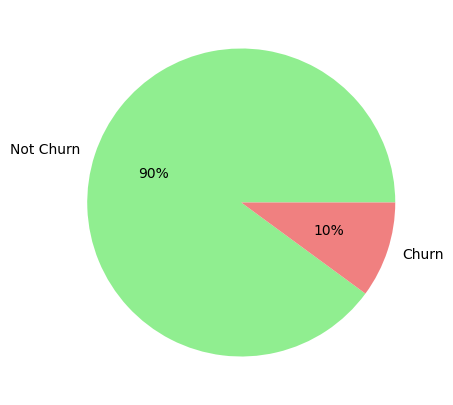

In [44]:
# Plot churn_probability
plt.figure(figsize= (6,5)) 
labels = ['Not Churn','Churn']
colors = ['lightgreen', 'lightcoral']
plt.pie(data_eda.churn_probability.value_counts(), labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()

The data is imbalanced so we may have to apply class imbalance techniques prior to training models

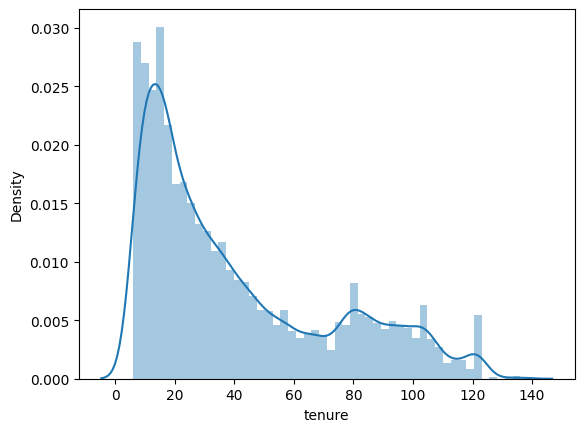

In [45]:
# Lets check churn probability w.r.t tenure or age on network varaible
data_eda["tenure"] = data_eda["aon"]/30
sns.distplot(data_eda["tenure"], bins=50)
plt.show()

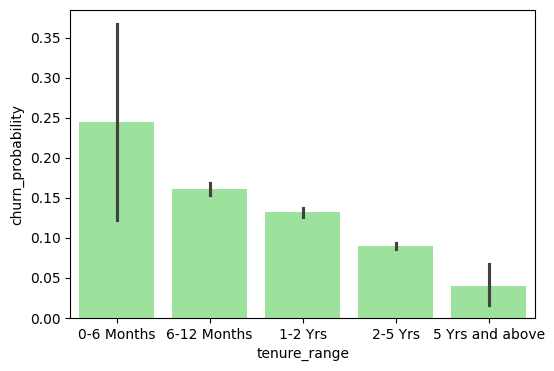

In [46]:
tenure_range = [0, 6, 12, 24, 60, 61]
tenure_label = ['0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
data_eda['tenure_range'] = pd.cut(data_eda['tenure'], tenure_range, labels=tenure_label)
plt.figure(figsize=[6,4])
sns.barplot(x='tenure_range', y='churn_probability', data=data_eda, color='lightgreen')
plt.show()

Its evident from above plot that maximum churn happens during first 6 months and as time goes by, less churn happens.

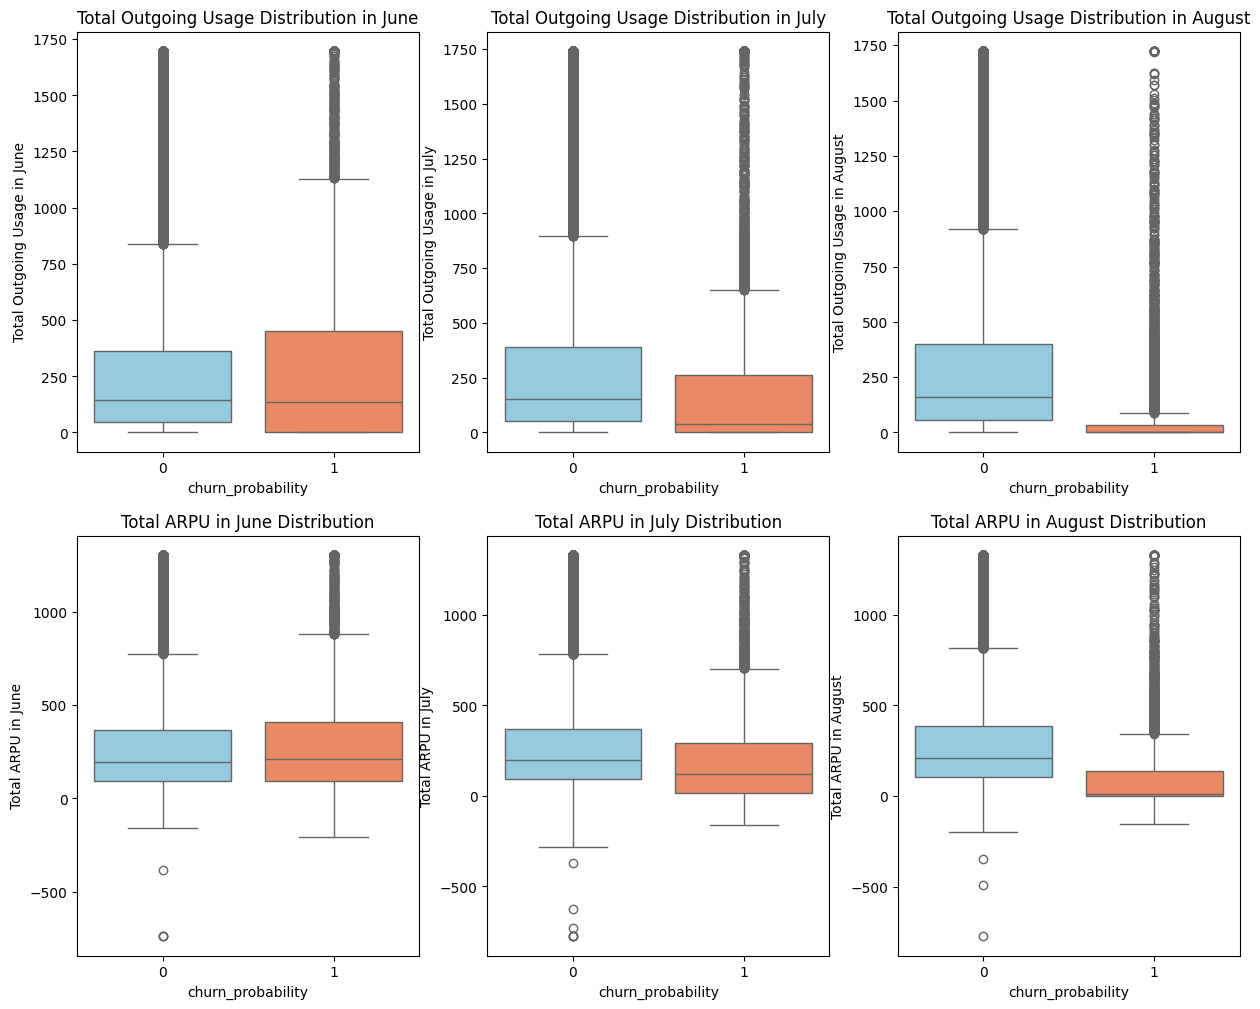

In [47]:
plt.figure(figsize=[15, 12])
plt.subplot(231)
sns.boxplot(x="churn_probability", y='total_og_mou_6', data=data_eda, palette=["skyblue", "coral"])
plt.ylabel('Total Outgoing Usage in June')
plt.title("Total Outgoing Usage Distribution in June")

plt.subplot(232)
sns.boxplot(x="churn_probability", y='total_og_mou_7', data=data_eda, palette=["skyblue", "coral"])
plt.ylabel('Total Outgoing Usage in July')
plt.title("Total Outgoing Usage Distribution in July")

plt.subplot(233)
sns.boxplot(x="churn_probability", y='total_og_mou_8', data=data_eda, palette=["skyblue", "coral"])
plt.ylabel('Total Outgoing Usage in August')
plt.title("Total Outgoing Usage Distribution in August")

plt.subplot(234)
sns.boxplot(x="churn_probability", y='arpu_6', data=data_eda, palette=["skyblue", "coral"])
plt.ylabel('Total ARPU in June')
plt.title("Total ARPU in June Distribution")

plt.subplot(235)
sns.boxplot(x="churn_probability", y='arpu_7', data=data_eda, palette=["skyblue", "coral"])
plt.ylabel('Total ARPU in July')
plt.title("Total ARPU in July Distribution")

plt.subplot(236)
sns.boxplot(x="churn_probability", y='arpu_8', data=data_eda, palette=["skyblue", "coral"])
plt.ylabel('Total ARPU in August')
plt.title("Total ARPU in August Distribution")

plt.show()

**Analysis**:

- Customers with higher outgoing calls in the sixth month with reduction of calls/usage in eighth month have a high chance of churning
- As the ARPU of the customer decreases from sixth to eighth month, the probability of churn increases

# 5. Feature Engineering and Selection

In this section we will try to add some derived metrics to increase the chances of a better model for example

- "Average gain/loss of 3g and 2g data volume from month 6 to 8" - (growth or decline of 3g usage month over month?)

- "Difference in usage for outgoing and incoming calls over 3 months etc.

It is also observed from data that so of these columns are just sum of individual usage, for example:-
"loc_og_mou_6" is just sum of usage of 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6' and 'loc_og_t2c_mou_6'. This will repeat for "loc_og_mou_7", ""loc_og_mou_8" etc.

Other variables also show similar trend like "std_og_mou_6", "loc_ic_mou_6" and their corresponding 7th and 8th months
Its best to just use the total variables and drop the individual compomnents.

After that we will compute differences of usage for roam, STD, ISD, data etc. from month 8 to month 7 and 6

In [48]:
pd.DataFrame(X_train_filtered.columns.T)

0
0                     arpu_6
1                     arpu_7
2                     arpu_8
3                onnet_mou_6
4                onnet_mou_7
5                onnet_mou_8
6               offnet_mou_6
7               offnet_mou_7
8               offnet_mou_8
9              roam_ic_mou_6
10             roam_ic_mou_7
11             roam_ic_mou_8
12             roam_og_mou_6
13             roam_og_mou_7
14             roam_og_mou_8
15          loc_og_t2t_mou_6
16          loc_og_t2t_mou_7
17          loc_og_t2t_mou_8
18          loc_og_t2m_mou_6
19          loc_og_t2m_mou_7
20          loc_og_t2m_mou_8
21          loc_og_t2f_mou_6
22          loc_og_t2f_mou_7
23          loc_og_t2f_mou_8
24          loc_og_t2c_mou_6
25          loc_og_t2c_mou_7
26          loc_og_t2c_mou_8
27              loc_og_mou_6
28              loc_og_mou_7
29              loc_og_mou_8
30          std_og_t2t_mou_6
31          std_og_t2t_mou_7
32          std_og_t2t_mou_8
33          std_og_t2m_mou_6
34          std_og_t2m_mou_7
35          std_og_t2m_mou_8
36          std_og_t2f_mou_6
37          std_og_t2f_mou_7
38          std_og_t2f_mou_8
39              std_og_mou_6
40              std_og_mou_7
41              std_og_mou_8
42              isd_og_mou_6
43              isd_og_mou_7
44              isd_og_mou_8
45              spl_og_mou_6
46              spl_og_mou_7
47              spl_og_mou_8
48               og_others_6
49               og_others_7
50               og_others_8
51            total_og_mou_6
52            total_og_mou_7
53            total_og_mou_8
54          loc_ic_t2t_mou_6
55          loc_ic_t2t_mou_7
56          loc_ic_t2t_mou_8
57          loc_ic_t2m_mou_6
58          loc_ic_t2m_mou_7
59          loc_ic_t2m_mou_8
60          loc_ic_t2f_mou_6
61          loc_ic_t2f_mou_7
62          loc_ic_t2f_mou_8
63              loc_ic_mou_6
64              loc_ic_mou_7
65              loc_ic_mou_8
66          std_ic_t2t_mou_6
67          std_ic_t2t_mou_7
68          std_ic_t2t_mou_8
69          std_ic_t2m_mou_6
70          std_ic_t2m_mou_7
71          std_ic_t2m_mou_8
72          std_ic_t2f_mou_6
73          std_ic_t2f_mou_7
74          std_ic_t2f_mou_8
75              std_ic_mou_6
76              std_ic_mou_7
77              std_ic_mou_8
78            total_ic_mou_6
79            total_ic_mou_7
80            total_ic_mou_8
81              spl_ic_mou_6
82              spl_ic_mou_7
83              spl_ic_mou_8
84              isd_ic_mou_6
85              isd_ic_mou_7
86              isd_ic_mou_8
87               ic_others_6
88               ic_others_7
89               ic_others_8
90          total_rech_num_6
91          total_rech_num_7
92          total_rech_num_8
93          total_rech_amt_6
94          total_rech_amt_7
95          total_rech_amt_8
96            max_rech_amt_6
97            max_rech_amt_7
98            max_rech_amt_8
99        last_day_rch_amt_6
100       last_day_rch_amt_7
101       last_day_rch_amt_8
102              vol_2g_mb_6
103              vol_2g_mb_7
104              vol_2g_mb_8
105              vol_3g_mb_6
106              vol_3g_mb_7
107              vol_3g_mb_8
108             monthly_2g_6
109             monthly_2g_7
110             monthly_2g_8
111              sachet_2g_6
112              sachet_2g_7
113              sachet_2g_8
114             monthly_3g_6
115             monthly_3g_7
116             monthly_3g_8
117              sachet_3g_6
118              sachet_3g_7
119              sachet_3g_8
120                      aon
121               aug_vbc_3g
122               jul_vbc_3g
123               jun_vbc_3g
124  days_from_last_recharge

In [49]:
X_train_filtered['arpu_diff'] = X_train_filtered.arpu_8 - ((X_train_filtered.arpu_6 + X_train_filtered.arpu_7)/2)

X_train_filtered['onnet_mou_diff'] = X_train_filtered.onnet_mou_8 - ((X_train_filtered.onnet_mou_6 + X_train_filtered.onnet_mou_7)/2)

X_train_filtered['offnet_mou_diff'] = X_train_filtered.offnet_mou_8 - ((X_train_filtered.offnet_mou_6 + X_train_filtered.offnet_mou_7)/2)

X_train_filtered['roam_ic_mou_diff'] = X_train_filtered.roam_ic_mou_8 - ((X_train_filtered.roam_ic_mou_6 + X_train_filtered.roam_ic_mou_7)/2)

X_train_filtered['roam_og_mou_diff'] = X_train_filtered.roam_og_mou_8 - ((X_train_filtered.roam_og_mou_6 + X_train_filtered.roam_og_mou_7)/2)

X_train_filtered['loc_og_mou_diff'] = X_train_filtered.loc_og_mou_8 - ((X_train_filtered.loc_og_mou_6 + X_train_filtered.loc_og_mou_7)/2)

X_train_filtered['std_og_mou_diff'] = X_train_filtered.std_og_mou_8 - ((X_train_filtered.std_og_mou_6 + X_train_filtered.std_og_mou_7)/2)

X_train_filtered['isd_og_mou_diff'] = X_train_filtered.isd_og_mou_8 - ((X_train_filtered.isd_og_mou_6 + X_train_filtered.isd_og_mou_7)/2)

X_train_filtered['spl_og_mou_diff'] = X_train_filtered.spl_og_mou_8 - ((X_train_filtered.spl_og_mou_6 + X_train_filtered.spl_og_mou_7)/2)

X_train_filtered['og_others_diff'] = X_train_filtered.og_others_8 - ((X_train_filtered.og_others_6 + X_train_filtered.og_others_7)/2)

X_train_filtered['total_og_mou_diff'] = X_train_filtered.total_og_mou_8 - ((X_train_filtered.total_og_mou_6 + X_train_filtered.total_og_mou_7)/2)

X_train_filtered['loc_ic_mou_diff'] = X_train_filtered.loc_ic_mou_8 - ((X_train_filtered.loc_ic_mou_6 + X_train_filtered.loc_ic_mou_7)/2)

X_train_filtered['std_ic_mou_diff'] = X_train_filtered.std_ic_mou_8 - ((X_train_filtered.std_ic_mou_6 + X_train_filtered.std_ic_mou_7)/2)

X_train_filtered['isd_ic_mou_diff'] = X_train_filtered.isd_ic_mou_8 - ((X_train_filtered.isd_ic_mou_6 + X_train_filtered.isd_ic_mou_7)/2)

X_train_filtered['spl_ic_mou_diff'] = X_train_filtered.spl_ic_mou_8 - ((X_train_filtered.spl_ic_mou_6 + X_train_filtered.spl_ic_mou_7)/2)

X_train_filtered['ic_others_diff'] = X_train_filtered.ic_others_8 - ((X_train_filtered.ic_others_6 + X_train_filtered.ic_others_7)/2)

X_train_filtered['total_ic_mou_diff'] = X_train_filtered.total_ic_mou_8 - ((X_train_filtered.total_ic_mou_6 + X_train_filtered.total_ic_mou_7)/2)

X_train_filtered['total_rech_num_diff'] = X_train_filtered.total_rech_num_8 - ((X_train_filtered.total_rech_num_6 + X_train_filtered.total_rech_num_7)/2)

X_train_filtered['total_rech_amt_diff'] = X_train_filtered.total_rech_amt_8 - ((X_train_filtered.total_rech_amt_6 + X_train_filtered.total_rech_amt_7)/2)

X_train_filtered['max_rech_amt_diff'] = X_train_filtered.max_rech_amt_8 - ((X_train_filtered.max_rech_amt_6 + X_train_filtered.max_rech_amt_7)/2)

X_train_filtered['vol_2g_mb_diff'] = X_train_filtered.vol_2g_mb_8 - ((X_train_filtered.vol_2g_mb_6 + X_train_filtered.vol_2g_mb_7)/2)

X_train_filtered['vol_3g_mb_diff'] = X_train_filtered.vol_3g_mb_8 - ((X_train_filtered.vol_3g_mb_6 + X_train_filtered.vol_3g_mb_7)/2)


In [50]:
columns_to_del = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',
                  'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8',
                  'std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8',
                  'std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8',
                  'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8',
                  'std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
                  'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
                  

In [51]:
X_train_filtered.drop(columns_to_del, axis=1, inplace = True)

In [52]:
pd.DataFrame(X_train_filtered.columns.T)

0
0                     arpu_6
1                     arpu_7
2                     arpu_8
3                onnet_mou_6
4                onnet_mou_7
5                onnet_mou_8
6               offnet_mou_6
7               offnet_mou_7
8               offnet_mou_8
9              roam_ic_mou_6
10             roam_ic_mou_7
11             roam_ic_mou_8
12             roam_og_mou_6
13             roam_og_mou_7
14             roam_og_mou_8
15              loc_og_mou_6
16              loc_og_mou_7
17              loc_og_mou_8
18              std_og_mou_6
19              std_og_mou_7
20              std_og_mou_8
21              isd_og_mou_6
22              isd_og_mou_7
23              isd_og_mou_8
24              spl_og_mou_6
25              spl_og_mou_7
26              spl_og_mou_8
27               og_others_6
28               og_others_7
29               og_others_8
30            total_og_mou_6
31            total_og_mou_7
32            total_og_mou_8
33              loc_ic_mou_6
34              loc_ic_mou_7
35              loc_ic_mou_8
36              std_ic_mou_6
37              std_ic_mou_7
38              std_ic_mou_8
39            total_ic_mou_6
40            total_ic_mou_7
41            total_ic_mou_8
42              spl_ic_mou_6
43              spl_ic_mou_7
44              spl_ic_mou_8
45              isd_ic_mou_6
46              isd_ic_mou_7
47              isd_ic_mou_8
48               ic_others_6
49               ic_others_7
50               ic_others_8
51          total_rech_num_6
52          total_rech_num_7
53          total_rech_num_8
54          total_rech_amt_6
55          total_rech_amt_7
56          total_rech_amt_8
57            max_rech_amt_6
58            max_rech_amt_7
59            max_rech_amt_8
60        last_day_rch_amt_6
61        last_day_rch_amt_7
62        last_day_rch_amt_8
63               vol_2g_mb_6
64               vol_2g_mb_7
65               vol_2g_mb_8
66               vol_3g_mb_6
67               vol_3g_mb_7
68               vol_3g_mb_8
69              monthly_2g_6
70              monthly_2g_7
71              monthly_2g_8
72               sachet_2g_6
73               sachet_2g_7
74               sachet_2g_8
75              monthly_3g_6
76              monthly_3g_7
77              monthly_3g_8
78               sachet_3g_6
79               sachet_3g_7
80               sachet_3g_8
81                       aon
82                aug_vbc_3g
83                jul_vbc_3g
84                jun_vbc_3g
85   days_from_last_recharge
86                 arpu_diff
87            onnet_mou_diff
88           offnet_mou_diff
89          roam_ic_mou_diff
90          roam_og_mou_diff
91           loc_og_mou_diff
92           std_og_mou_diff
93           isd_og_mou_diff
94           spl_og_mou_diff
95            og_others_diff
96         total_og_mou_diff
97           loc_ic_mou_diff
98           std_ic_mou_diff
99           isd_ic_mou_diff
100          spl_ic_mou_diff
101           ic_others_diff
102        total_ic_mou_diff
103      total_rech_num_diff
104      total_rech_amt_diff
105        max_rech_amt_diff
106           vol_2g_mb_diff
107           vol_3g_mb_diff

Finalize X_train variables prior to Feature scaling and modelling

In [53]:
final_columns = X_train_filtered.columns
final_columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'std_ic_mou_diff', 'isd_ic_mou_diff', 'spl_ic_mou_diff',
       'ic_others_diff', 'total_ic_mou_diff', 'total_rech_num_diff',
       'total_rech_amt_diff', 'max_rech_amt_diff', 'vol_2g_mb_diff',
       'vol_3g_mb_diff'],
      dtype='object', length=108)

When we do test data transformation, we will need to have final columns as well as derived columns. Lets get the base columns differentiated from new engineered columns

In [54]:
derived_cols = ['days_from_last_recharge','arpu_diff','onnet_mou_diff','offnet_mou_diff','roam_ic_mou_diff','roam_og_mou_diff','loc_og_mou_diff',
                'std_og_mou_diff','isd_og_mou_diff','spl_og_mou_diff','og_others_diff','total_og_mou_diff','loc_ic_mou_diff','std_ic_mou_diff',
                'isd_ic_mou_diff','spl_ic_mou_diff','ic_others_diff','total_ic_mou_diff','total_rech_num_diff','total_rech_amt_diff','max_rech_amt_diff',
                'vol_2g_mb_diff','vol_3g_mb_diff']
base_final_cols = final_columns.difference(derived_cols)
base_final_cols

Index(['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'aug_vbc_3g', 'ic_others_6',
       'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7',
       'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7',
       'last_day_rch_amt_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'sachet_2g_6',
       'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_

## 5.1 Feature Scaling

We sill use a Standard Scaler to scale the numerical features

In [55]:
# Scale the features. All features now in X_train are numerical
scale = StandardScaler()
X_train_final_scaled = scale.fit_transform(X_train_filtered)

In [56]:
pd.DataFrame(X_train_final_scaled, columns=final_columns).head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  0.569269  0.157532  0.560809     0.056537    -0.295834    -0.390792   
1  0.381895 -1.007273 -0.652820    -0.543783    -0.537528    -0.532742   
2 -0.749705 -0.822629 -0.844747    -0.489548    -0.527829    -0.508791   
3  2.569102  4.006435  3.958661     4.301493     4.337699     4.369645   
4 -0.736498 -0.828374 -0.949229    -0.500663    -0.483948    -0.489488   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0     -0.141729     -0.393795     -0.267277      -0.257567      -0.218790   
1      0.093981     -0.727295     -0.462280       1.070464       0.101782   
2     -0.618160     -0.628093     -0.669363      -0.257567      -0.218790   
3     -0.429524     -0.167016     -0.521596      -0.257567      -0.218790   
4     -0.640771     -0.659291     -0.653478      -0.257567      -0.218790   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_mou_6  \
0      -0.220581      -0.280137       -0.24861      -0.239383      0.787926   
1      -0.195425       4.002265       -0.19783      -0.239383     -0.672791   
2      -0.220581      -0.280137       -0.24861      -0.239383     -0.468408   
3      -0.220581      -0.263419       -0.24861      -0.239383     -0.451648   
4      -0.220581      -0.280137       -0.24861      -0.239383     -0.561169   

   loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0      0.044502      0.091139     -0.500744     -0.501032     -0.495787   
1     -0.709969     -0.555889     -0.359936     -0.501032     -0.371426   
2     -0.555491     -0.595293     -0.500744     -0.501032     -0.495787   
3     -0.518864     -0.390787      3.987016      3.994473      3.989769   
4     -0.628067     -0.594896     -0.469734     -0.461541     -0.469973   

   isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0     -0.087489     -0.088736     -0.082993     -0.411265     -0.309870   
1     -0.087489     -0.088736     -0.082993     -0.411265     -0.423515   
2     -0.087489     -0.088736     -0.082993     -0.411265     -0.423515   
3     -0.087489     -0.088736     -0.082993      0.823797      1.274957   
4     -0.087489     -0.088736     -0.082993     -0.411265      0.066191   

   spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0     -0.445637     0.134248    -0.041154    -0.044926       -0.048097   
1     -0.233477    -0.287530    -0.041154    -0.044926       -0.640626   
2     -0.362523    -0.287530    -0.041154    -0.044926       -0.651976   
3      2.604437     1.305044    -0.041154    -0.044926        3.737261   
4     -0.371272    -0.287530    -0.041154    -0.044926       -0.672370   

   total_og_mou_7  total_og_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
0       -0.411026       -0.386419      4.039542      3.800659      0.035743   
1       -0.759641       -0.581451     -0.687143     -0.812492     -0.735782   
2       -0.688846       -0.700758      1.221637      0.726248      0.643761   
3        3.753256        3.755578     -0.383140     -0.553163     -0.539499   
4       -0.678536       -0.680430     -0.470526     -0.664466     -0.522489   

   std_ic_mou_6  std_ic_mou_7  std_ic_mou_8  total_ic_mou_6  total_ic_mou_7  \
0     -0.474199     -0.469026     -0.468269        3.966369        2.964305   
1      0.053520     -0.469026      0.375840       -0.614872       -0.850544   
2     -0.475983     -0.469026     -0.468269        0.856486        0.421919   
3     -0.248696      0.068574     -0.445623       -0.435440       -0.492797   
4     -0.413720     -0.469026     -0.398949       -0.550532       -0.713127   

   total_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  \
0       -0.145982     -0.436227     -0.301585     -0.318052     -0.213554   
1       -0.567031     -0.436227     -0.301585     -0.318052     -0.213554   
2        0.359995     -0.436227     -0.301585     -0.318052     -0.213554   
3       -0.618797

We need to handle Class imbalance using one of the industry methdologies SMOTE - Synthetic Minority Oversampling Technique

In [57]:
oversample = SMOTE(random_state=100, sampling_strategy=0.3)

In [58]:
X_train_model1, y_train_model1 = oversample.fit_resample(X_train_final_scaled, y_train)

In [59]:
from collections import Counter
counter = Counter(y_train_model1)
counter

Counter({0: 50358, 1: 15107})

So for "Churn" classes we have increased the samples to be equal to 30% of "Non-Churn" cases

# 6. Model Building and Evaluation

Before we start model building, in order to quickly reach an efficient model building and evaluation we will use dimensionality reduction technique like PCA (Principal Component Analysis)

Our train data has around 108 columns after data manipulation and feature engineering. That is a lot of columns, so we will use PCA to highlight optimum number of components for model building

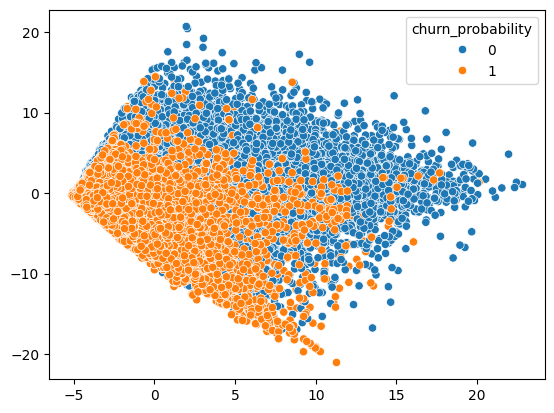

In [60]:
# Initialize PCA
pca = PCA()
pca_components = pca.fit_transform(X_train_model1)
#pca_components = pca.fit_transform(X_train_final_scaled)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train_model1)
#sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

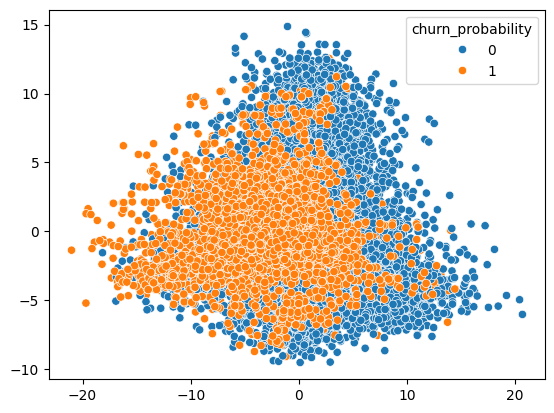

In [61]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train_model1)
#sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)
plt.show()

Since we have oversampled the "Churn" classes, we see a good representation of the same in the visualization in the first 3 PCA components

Lets see how many PCA components are able to explain more than 90% of variance in the model


In [62]:
pca.components_

array([[ 2.05821033e-01,  2.27124948e-01,  2.10194972e-01, ...,
         1.75686877e-02,  1.32622947e-03,  8.04793073e-03],
       [-1.25585892e-01, -2.21581560e-02,  1.42910794e-01, ...,
         1.61733015e-01,  3.89092295e-02,  5.57757811e-02],
       [ 1.90353028e-02, -2.14805971e-03, -1.66585669e-02, ...,
        -2.87558415e-02, -2.72236443e-02, -1.56403791e-02],
       ...,
       [ 0.00000000e+00,  1.98737893e-15,  1.35842485e-14, ...,
         1.70740672e-01, -7.86390335e-02,  4.51769901e-04],
       [-0.00000000e+00,  3.38193267e-15, -1.72173453e-15, ...,
        -2.77429507e-02,  1.28536904e-02, -1.19285701e-02],
       [ 0.00000000e+00, -1.58935011e-15,  7.67600776e-16, ...,
        -7.14162381e-02,  2.86393350e-02, -2.55486164e-02]])

In [63]:
# Percentage of variances explained by the components
pca.explained_variance_ratio_

array([1.36291555e-01, 9.26933153e-02, 6.38384291e-02, 4.82859635e-02,
       4.00358101e-02, 3.27171787e-02, 3.05559692e-02, 2.77603704e-02,
       2.36794814e-02, 2.27854783e-02, 2.12566232e-02, 1.94429773e-02,
       1.91629235e-02, 1.83997097e-02, 1.66193789e-02, 1.62356254e-02,
       1.57774231e-02, 1.50439975e-02, 1.47531136e-02, 1.41647590e-02,
       1.35780096e-02, 1.33604301e-02, 1.27915657e-02, 1.22842199e-02,
       1.20358322e-02, 1.19923450e-02, 1.12420484e-02, 1.09768568e-02,
       1.05921660e-02, 1.00409944e-02, 9.79812507e-03, 9.51840431e-03,
       9.12616066e-03, 9.03712323e-03, 8.89613317e-03, 7.55196500e-03,
       7.29159501e-03, 7.07898092e-03, 6.39296609e-03, 6.21641824e-03,
       5.75686729e-03, 5.65144772e-03, 5.37282619e-03, 5.26386512e-03,
       5.03165577e-03, 4.69047694e-03, 4.65509991e-03, 4.58819205e-03,
       4.55290644e-03, 4.33764355e-03, 4.19317708e-03, 4.11580007e-03,
       3.65258875e-03, 3.48273886e-03, 3.40530264e-03, 3.29922030e-03,
      

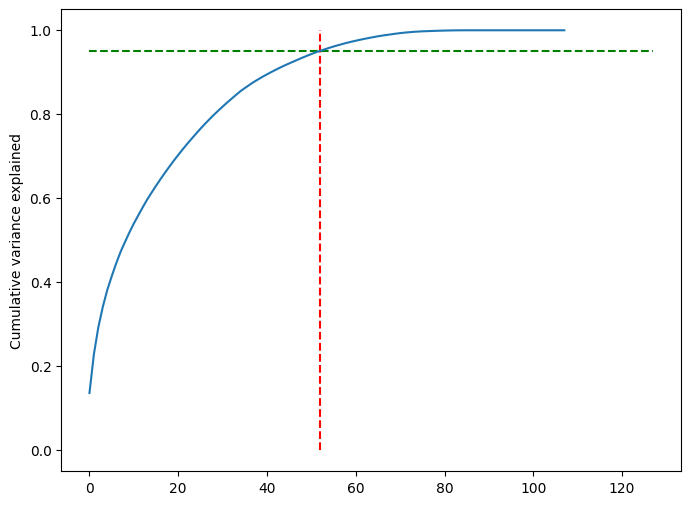

In [64]:
# Lets make a Scree plot for the explained variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[8,6])
plt.vlines(x=52, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=127, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

Looks like around 50 components would be required to explain around 95% of the variance in the model

In [65]:
#Consider features contributing to 95% variance
pca2 = PCA(n_components=52)
pca_components2 = pca2.fit_transform(X_train_model1)

In [66]:
# Build a Logistics Regression Base Model on this PCA
# Model 1
logreg = LogisticRegression(random_state=55, max_iter=1000, tol=0.001, solver='sag')
lr_model = logreg.fit(pca_components2, y_train_model1)
# model1 = logreg.fit(pca_components2, y_train)

In [67]:
# Get accuracy score of this model
lr_model.score(pca_components2, y_train_model1)

0.8805315817612465

In [68]:
# Predict on train dataset
y_train_pca2_pred = lr_model.predict(pca_components2)

In [69]:
print(classification_report(y_train_model1, y_train_pca2_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     50358
           1       0.77      0.69      0.73     15107

    accuracy                           0.88     65465
   macro avg       0.84      0.81      0.83     65465
weighted avg       0.88      0.88      0.88     65465



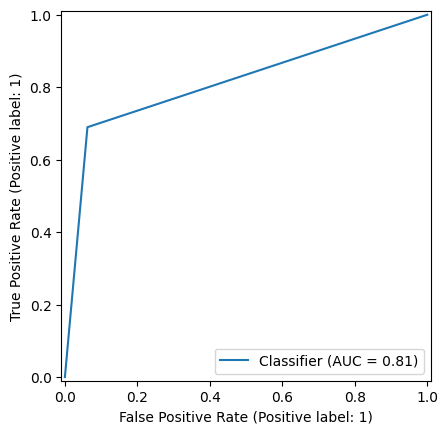

In [70]:
# Plot an ROC Curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_train_model1, y_train_pca2_pred)
plt.show()

In [71]:
# Plot the confusion matrix
confusion_matrix(y_train_model1, y_train_pca2_pred)

array([[47225,  3133],
       [ 4688, 10419]])

Lets use an ensemble technique like RandomForest to see if the scoring improves



In [72]:
len(pca2.components_)

52

Lets build an initial Ensemble model like Random forest on the original X_train dataset (108 features) to understand feature importances

In [73]:
# Model 2
rf = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=10, n_jobs=-1, oob_score=True)
rf_model1 = rf.fit(X_train_model1, y_train_model1)

In [74]:
# Lets see the Feature importances
feature_importances = pd.DataFrame({'col':final_columns, 'importance':rf.feature_importances_})
feature_importances.sort_values(by="importance", ascending=False)

col  importance
41            total_ic_mou_8    0.125108
32            total_og_mou_8    0.088026
35              loc_ic_mou_8    0.086232
8               offnet_mou_8    0.045896
56          total_rech_amt_8    0.043370
2                     arpu_8    0.040719
62        last_day_rch_amt_8    0.037370
17              loc_og_mou_8    0.036348
5                onnet_mou_8    0.028750
11             roam_ic_mou_8    0.026938
38              std_ic_mou_8    0.024019
14             roam_og_mou_8    0.023510
59            max_rech_amt_8    0.022304
53          total_rech_num_8    0.018204
85   days_from_last_recharge    0.018015
90          roam_og_mou_diff    0.017884
97           loc_ic_mou_diff    0.017510
86                 arpu_diff    0.017265
104      total_rech_amt_diff    0.015871
105        max_rech_amt_diff    0.014563
40            total_ic_mou_7    0.013830
31            total_og_mou_7    0.013717
89          roam_ic_mou_diff    0.011932
102        total_ic_mou_diff    0.010670
34              loc_ic_mou_7    0.009368
65               vol_2g_mb_8    0.008290
1                     arpu_7    0.006991
98           std_ic_mou_diff    0.006966
91           loc_og_mou_diff    0.006739
92           std_og_mou_diff    0.006279
68               vol_3g_mb_8    0.006050
16              loc_og_mou_7    0.006024
20              std_og_mou_8    0.006019
96         total_og_mou_diff    0.005485
33              loc_ic_mou_6    0.005227
81                       aon    0.005002
88           offnet_mou_diff    0.004996
13             roam_og_mou_7    0.004944
39            total_ic_mou_6    0.004501
26              spl_og_mou_8    0.004430
4                onnet_mou_7    0.004299
106           vol_2g_mb_diff    0.003817
52          total_rech_num_7    0.003705
103      total_rech_num_diff    0.003613
19              std_og_mou_7    0.003549
10             roam_ic_mou_7    0.003422
57            max_rech_amt_6    0.003293
51          total_rech_num_6    0.003220
15              loc_og_mou_6    0.002875
87            onnet_mou_diff    0.002769
30            total_og_mou_6    0.002641
61        last_day_rch_amt_7    0.002611
37              std_ic_mou_7    0.002530
100          spl_ic_mou_diff    0.002516
55          total_rech_amt_7    0.002382
7               offnet_mou_7    0.002349
58            max_rech_amt_7    0.002344
44              spl_ic_mou_8    0.002289
6               offnet_mou_6    0.002226
0                     arpu_6    0.002220
94           spl_og_mou_diff    0.002174
25              spl_og_mou_7    0.002072
18              std_og_mou_6    0.001997
3                onnet_mou_6    0.001928
67               vol_3g_mb_7    0.001905
54          total_rech_amt_6    0.001851
82                aug_vbc_3g    0.001713
60        last_day_rch_amt_6    0.001651
101           ic_others_diff    0.001566
64               vol_2g_mb_7    0.001544
107           vol_3g_mb_diff    0.001541
36              std_ic_mou_6    0.001511
12             roam_og_mou_6    0.001454
74               sachet_2g_8    0.001418
9              roam_ic_mou_6    0.001403
70              monthly_2g_7    0.001265
93           isd_og_mou_diff    0.001236
99           isd_ic_mou_diff    0.001186
23              isd_og_mou_8    0.001172
24              spl_og_mou_6    0.001076
63               vol_2g_mb_6    0.001029
50               ic_others_8    0.001010
77              monthly_3g_8    0.000991
47              isd_ic_mou_8    0.000812
46              isd_ic_mou_7    0.000780
95            og_others_diff    0.000748
73               sachet_2g_7    0.000716
27               og_others_6    0.000708
21              isd_og_mou_6    0.000646
48               ic_others_6    0.000605
66               vol_3g_mb_6    0.000599
49               ic_others_7    0.000527
83                jul_vbc_3g    0.000520
84                jun_vbc_3g    0.000513
45              isd_ic_mou_6    0.000507
42              spl_ic_mou_6    0.000479
22              isd_og_mou_7    0.000456
72     

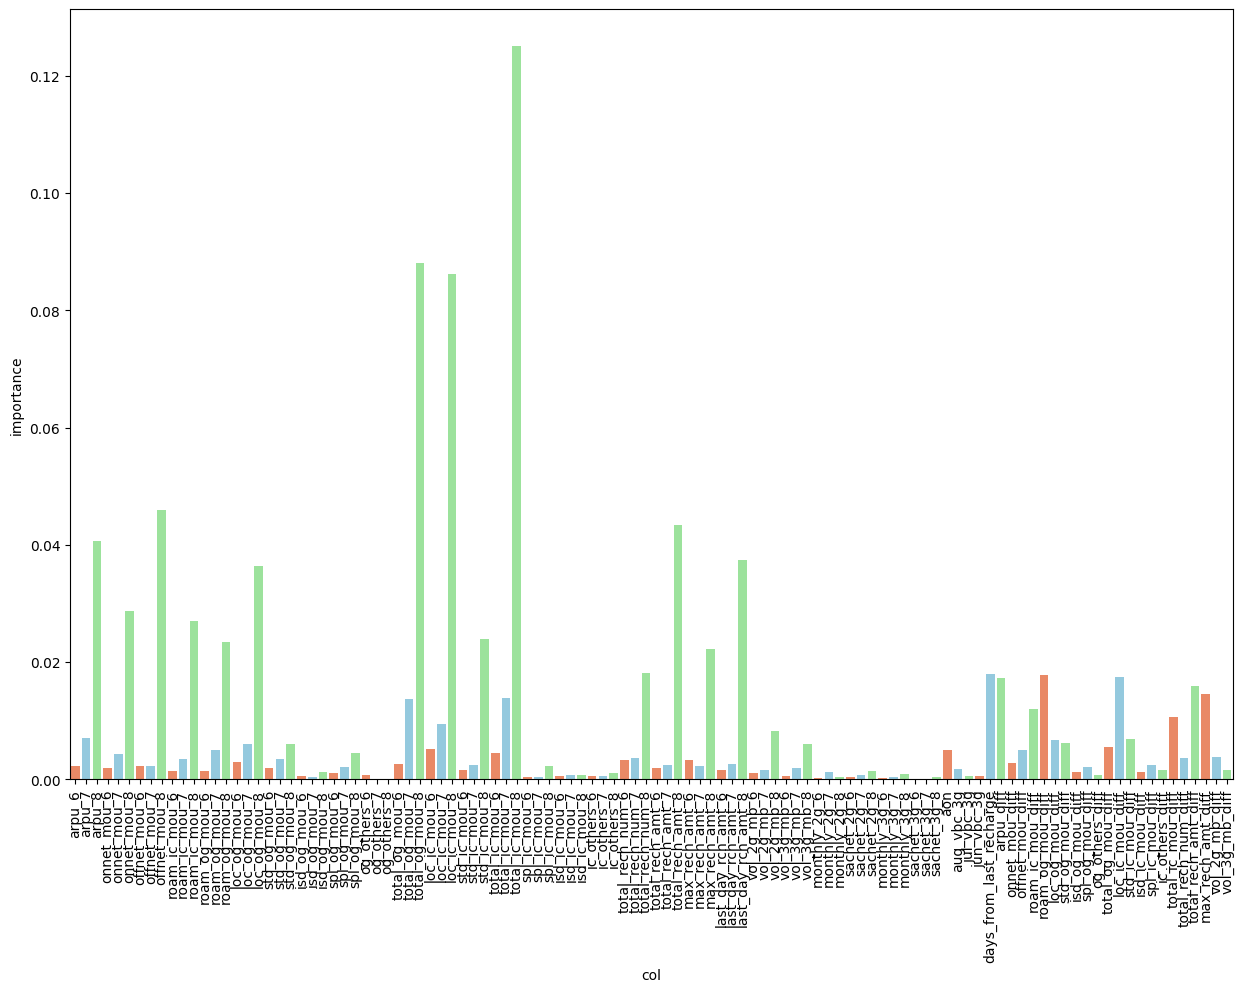

In [75]:
# Lets plot them
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot(x=feature_importances['col'], y=feature_importances['importance'], palette=['coral', 'skyblue', 'lightgreen'])
plt.show()

In [76]:
y_train_rf_predict = rf_model1.predict(X_train_model1)
print(classification_report(y_train_model1, y_train_rf_predict))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     50358
           1       0.90      0.83      0.86     15107

    accuracy                           0.94     65465
   macro avg       0.93      0.90      0.91     65465
weighted avg       0.94      0.94      0.94     65465



In [77]:
# Build a random forest model with the PCA components

rf2 = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=7, n_jobs=-1, oob_score=True)
rf_model2 = rf2.fit(pca_components2, y_train_model1)

In [78]:
y_train_rf2_predict = rf_model2.predict(pca_components2)

In [79]:
print(classification_report(y_train_model1, y_train_rf2_predict))


              precision    recall  f1-score   support

           0       0.92      0.97      0.95     50358
           1       0.89      0.73      0.80     15107

    accuracy                           0.92     65465
   macro avg       0.91      0.85      0.87     65465
weighted avg       0.91      0.92      0.91     65465



In [80]:
# Tune the RandomForest with few selected Hyperparameters
# Model 3
rf_tuned = RandomForestClassifier(random_state=55, n_jobs=-1)
param_grid = {
    "criterion": ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 20],
    'n_estimators': [10, 30, 50, 70, 75],
    'max_features' : [4, 7, 8, 10]
}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = RandomizedSearchCV(estimator=rf_tuned, param_distributions=param_grid, cv=folds, n_jobs=-1, n_iter=20, scoring='accuracy', random_state=100)

In [81]:
%%time
cv_results.fit(pca_components2, y_train_model1)
# cv_results.fit(pca_components2, y_train)

CPU times: user 1min 24s, sys: 1.17 s, total: 1min 25s
Wall time: 5min 27s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=55),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 20],
                                        'max_features': [4, 7, 8, 10],
                                        'n_estimators': [10, 30, 50, 70, 75]},
                   random_state=100, scoring='accuracy')

In [82]:
cv_results.best_estimator_

RandomForestClassifier(max_depth=20, max_features=8, n_estimators=70, n_jobs=-1,
                       random_state=55)

In [83]:
cv_results.best_params_

{'n_estimators': 70, 'max_features': 8, 'max_depth': 20, 'criterion': 'gini'}

In [84]:
rf_best = cv_results.best_estimator_

In [85]:
y_pred_rf_tuned = rf_best.predict(pca_components2)

In [86]:
print(classification_report(y_train_model1, y_pred_rf_tuned))
# print(classification_report(y_train, y_pred_rf_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50358
           1       0.99      0.99      0.99     15107

    accuracy                           1.00     65465
   macro avg       0.99      1.00      1.00     65465
weighted avg       1.00      1.00      1.00     65465



Looks like the model overfit. Lets try it on the non-PCA features

In [87]:
%%time
cv_results.fit(X_train_model1, y_train_model1)

CPU times: user 41.3 s, sys: 561 ms, total: 41.9 s
Wall time: 2min 31s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=55),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 20],
                                        'max_features': [4, 7, 8, 10],
                                        'n_estimators': [10, 30, 50, 70, 75]},
                   random_state=100, scoring='accuracy')

In [88]:
cv_results.best_params_

{'n_estimators': 70, 'max_features': 8, 'max_depth': 20, 'criterion': 'gini'}

In [89]:
# Model 4
rf_best2 = cv_results.best_estimator_

In [90]:
y_pred_rf_tuned2 = rf_best2.predict(X_train_model1)
print(classification_report(y_train_model1, y_pred_rf_tuned2))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     50358
           1       0.97      0.99      0.98     15107

    accuracy                           0.99     65465
   macro avg       0.98      0.99      0.98     65465
weighted avg       0.99      0.99      0.99     65465



Lets perform a Hyperparameter Tuning for Logistic Regression using PCA

In [91]:
# Model 5
logreg2 = LogisticRegression(random_state=55, max_iter=1000, tol=0.001, solver='sag')

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

#hyperparameter tuning
params={'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
        'penalty': ['l1', 'l2']
       }
cv_results_lr = RandomizedSearchCV(estimator=logreg2, param_distributions=params, cv=folds, n_jobs=-1, n_iter=30, scoring='accuracy', random_state=100)


In [92]:
%%time
cv_results_lr.fit(pca_components2, y_train_model1)

CPU times: user 1.05 s, sys: 72.7 ms, total: 1.12 s
Wall time: 9.02 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
                   estimator=LogisticRegression(max_iter=1000, random_state=55,
                                                solver='sag', tol=0.001),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                                        'penalty': ['l1', 'l2']},
                   random_state=100, scoring='accuracy')

In [93]:
cv_results_lr.best_params_

{'penalty': 'l2', 'C': 1}

In [94]:
cv_results_lr.best_estimator_

LogisticRegression(C=1, max_iter=1000, random_state=55, solver='sag', tol=0.001)

In [95]:
lr_best = cv_results_lr.best_estimator_
y_pred_lr_tuned = lr_best.predict(pca_components2)
print(classification_report(y_train_model1, y_pred_lr_tuned))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     50358
           1       0.77      0.69      0.73     15107

    accuracy                           0.88     65465
   macro avg       0.84      0.81      0.83     65465
weighted avg       0.88      0.88      0.88     65465



Lets try another Ensemble model for boosting - XGBoostClassifier and train it on original non-PCA features to compare feature importances with RandomForestClassifier

In [96]:
# Model 6

xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight=1, learning_rate=0.01, max_depth=10, reg_lambda=0.2, max_features=10)

In [97]:
xgb_model = xgb.fit(X_train_model1, y_train_model1)

In [98]:
y_train_xgb_predict = xgb_model.predict(X_train_model1)

In [99]:
print(classification_report(y_train_model1, y_train_xgb_predict))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     50358
           1       0.93      0.85      0.89     15107

    accuracy                           0.95     65465
   macro avg       0.94      0.92      0.93     65465
weighted avg       0.95      0.95      0.95     65465



In [100]:
# Lets see the Feature importances
feature_importances_xgb = pd.DataFrame({'col':final_columns, 'importance':xgb.feature_importances_})
feature_importances_xgb.sort_values(by="importance", ascending=False)

col  importance
41            total_ic_mou_8    0.416674
14             roam_og_mou_8    0.103645
65               vol_2g_mb_8    0.029351
35              loc_ic_mou_8    0.021918
62        last_day_rch_amt_8    0.020343
32            total_og_mou_8    0.013975
85   days_from_last_recharge    0.013519
44              spl_ic_mou_8    0.013219
56          total_rech_amt_8    0.011617
102        total_ic_mou_diff    0.009234
19              std_og_mou_7    0.008929
68               vol_3g_mb_8    0.008917
22              isd_og_mou_7    0.008023
70              monthly_2g_7    0.006698
59            max_rech_amt_8    0.006664
86                 arpu_diff    0.006439
92           std_og_mou_diff    0.006217
53          total_rech_num_8    0.006174
52          total_rech_num_7    0.005928
81                       aon    0.005601
31            total_og_mou_7    0.005560
11             roam_ic_mou_8    0.005421
104      total_rech_amt_diff    0.005208
23              isd_og_mou_8    0.005031
93           isd_og_mou_diff    0.004796
33              loc_ic_mou_6    0.004650
25              spl_og_mou_7    0.004495
57            max_rech_amt_6    0.004495
51          total_rech_num_6    0.004426
39            total_ic_mou_6    0.004374
82                aug_vbc_3g    0.004369
77              monthly_3g_8    0.004282
58            max_rech_amt_7    0.004138
96         total_og_mou_diff    0.004135
13             roam_og_mou_7    0.004079
61        last_day_rch_amt_7    0.003978
40            total_ic_mou_7    0.003949
21              isd_og_mou_6    0.003885
101           ic_others_diff    0.003876
46              isd_ic_mou_7    0.003814
99           isd_ic_mou_diff    0.003674
105        max_rech_amt_diff    0.003565
90          roam_og_mou_diff    0.003557
34              loc_ic_mou_7    0.003533
37              std_ic_mou_7    0.003480
9              roam_ic_mou_6    0.003477
107           vol_3g_mb_diff    0.003415
47              isd_ic_mou_8    0.003362
20              std_og_mou_8    0.003333
98           std_ic_mou_diff    0.003333
6               offnet_mou_6    0.003322
15              loc_og_mou_6    0.003310
97           loc_ic_mou_diff    0.003303
16              loc_og_mou_7    0.003280
30            total_og_mou_6    0.003253
10             roam_ic_mou_7    0.003195
94           spl_og_mou_diff    0.003176
18              std_og_mou_6    0.003149
38              std_ic_mou_8    0.003138
100          spl_ic_mou_diff    0.003124
0                     arpu_6    0.003100
55          total_rech_amt_7    0.003068
49               ic_others_7    0.003049
24              spl_og_mou_6    0.003043
12             roam_og_mou_6    0.003041
72               sachet_2g_6    0.003020
17              loc_og_mou_8    0.003015
88           offnet_mou_diff    0.002925
54          total_rech_amt_6    0.002917
89          roam_ic_mou_diff    0.002902
103      total_rech_num_diff    0.002900
74               sachet_2g_8    0.002863
71              monthly_2g_8    0.002843
5                onnet_mou_8    0.002832
29               og_others_8    0.002823
8               offnet_mou_8    0.002815
76              monthly_3g_7    0.002801
91           loc_og_mou_diff    0.002800
75              monthly_3g_6    0.002799
3                onnet_mou_6    0.002798
26              spl_og_mou_8    0.002761
60        last_day_rch_amt_6    0.002741
50               ic_others_8    0.002722
48               ic_others_6    0.002710
87            onnet_mou_diff    0.002621
84                jun_vbc_3g    0.002615
4                onnet_mou_7    0.002603
106           vol_2g_mb_diff    0.002591
36              std_ic_mou_6    0.002531
66               vol_3g_mb_6    0.002515
7               offnet_mou_7    0.002485
2                     arpu_8    0.002459
42              spl_ic_mou_6    0.002457
27               og_others_6    0.002446
69              monthly_2g_6    0.002408
67               vol_3g_mb_7    0.002380
1                     arpu_7    0.002348
43     

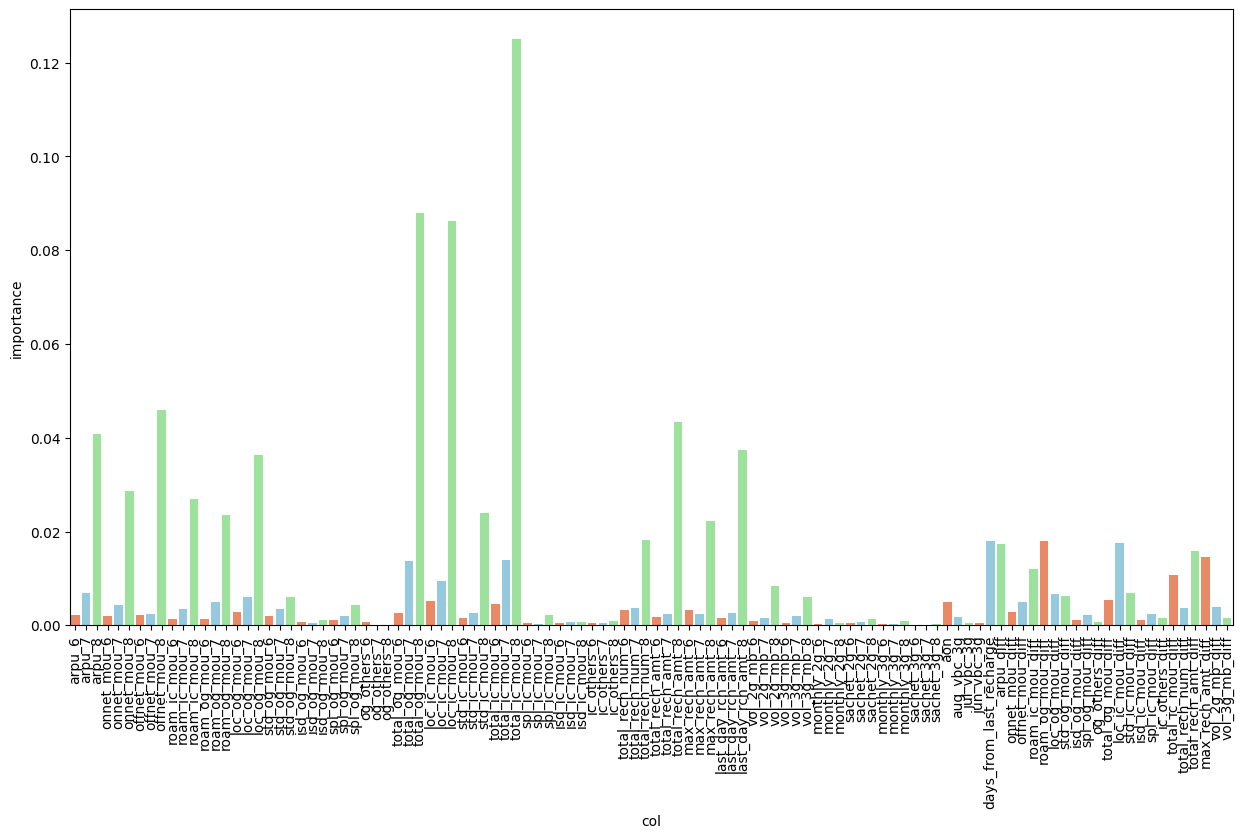

In [101]:
# Lets plot them
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.barplot(x=feature_importances_xgb['col'], y=feature_importances['importance'], palette=['coral', 'skyblue', 'lightgreen'])
plt.show()

Lets create a model with the top 30 features using the RandomForestClassifier Model 1 and XGBoostClassifier which performed the best amongs all the models so far with a good balance of accuracy, recall and precision. We will not use the PCA components for this, but the original top 30 features by importance

In [102]:
# extract top 'n' features

top_features = feature_importances.sort_values(by="importance", ascending=False)
top_features = top_features.reset_index().loc[:29, 'col']
top_features

0              total_ic_mou_8
1              total_og_mou_8
2                loc_ic_mou_8
3                offnet_mou_8
4            total_rech_amt_8
5                      arpu_8
6          last_day_rch_amt_8
7                loc_og_mou_8
8                 onnet_mou_8
9               roam_ic_mou_8
10               std_ic_mou_8
11              roam_og_mou_8
12             max_rech_amt_8
13           total_rech_num_8
14    days_from_last_recharge
15           roam_og_mou_diff
16            loc_ic_mou_diff
17                  arpu_diff
18        total_rech_amt_diff
19          max_rech_amt_diff
20             total_ic_mou_7
21             total_og_mou_7
22           roam_ic_mou_diff
23          total_ic_mou_diff
24               loc_ic_mou_7
25                vol_2g_mb_8
26                     arpu_7
27            std_ic_mou_diff
28            loc_og_mou_diff
29            std_og_mou_diff
Name: col, dtype: object

In [103]:
X_train_model1_df = pd.DataFrame(X_train_model1, columns=final_columns)
X_train_model1_df.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  0.569269  0.157532  0.560809     0.056537    -0.295834    -0.390792   
1  0.381895 -1.007273 -0.652820    -0.543783    -0.537528    -0.532742   
2 -0.749705 -0.822629 -0.844747    -0.489548    -0.527829    -0.508791   
3  2.569102  4.006435  3.958661     4.301493     4.337699     4.369645   
4 -0.736498 -0.828374 -0.949229    -0.500663    -0.483948    -0.489488   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0     -0.141729     -0.393795     -0.267277      -0.257567      -0.218790   
1      0.093981     -0.727295     -0.462280       1.070464       0.101782   
2     -0.618160     -0.628093     -0.669363      -0.257567      -0.218790   
3     -0.429524     -0.167016     -0.521596      -0.257567      -0.218790   
4     -0.640771     -0.659291     -0.653478      -0.257567      -0.218790   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_mou_6  \
0      -0.220581      -0.280137       -0.24861      -0.239383      0.787926   
1      -0.195425       4.002265       -0.19783      -0.239383     -0.672791   
2      -0.220581      -0.280137       -0.24861      -0.239383     -0.468408   
3      -0.220581      -0.263419       -0.24861      -0.239383     -0.451648   
4      -0.220581      -0.280137       -0.24861      -0.239383     -0.561169   

   loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0      0.044502      0.091139     -0.500744     -0.501032     -0.495787   
1     -0.709969     -0.555889     -0.359936     -0.501032     -0.371426   
2     -0.555491     -0.595293     -0.500744     -0.501032     -0.495787   
3     -0.518864     -0.390787      3.987016      3.994473      3.989769   
4     -0.628067     -0.594896     -0.469734     -0.461541     -0.469973   

   isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0     -0.087489     -0.088736     -0.082993     -0.411265     -0.309870   
1     -0.087489     -0.088736     -0.082993     -0.411265     -0.423515   
2     -0.087489     -0.088736     -0.082993     -0.411265     -0.423515   
3     -0.087489     -0.088736     -0.082993      0.823797      1.274957   
4     -0.087489     -0.088736     -0.082993     -0.411265      0.066191   

   spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0     -0.445637     0.134248    -0.041154    -0.044926       -0.048097   
1     -0.233477    -0.287530    -0.041154    -0.044926       -0.640626   
2     -0.362523    -0.287530    -0.041154    -0.044926       -0.651976   
3      2.604437     1.305044    -0.041154    -0.044926        3.737261   
4     -0.371272    -0.287530    -0.041154    -0.044926       -0.672370   

   total_og_mou_7  total_og_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
0       -0.411026       -0.386419      4.039542      3.800659      0.035743   
1       -0.759641       -0.581451     -0.687143     -0.812492     -0.735782   
2       -0.688846       -0.700758      1.221637      0.726248      0.643761   
3        3.753256        3.755578     -0.383140     -0.553163     -0.539499   
4       -0.678536       -0.680430     -0.470526     -0.664466     -0.522489   

   std_ic_mou_6  std_ic_mou_7  std_ic_mou_8  total_ic_mou_6  total_ic_mou_7  \
0     -0.474199     -0.469026     -0.468269        3.966369        2.964305   
1      0.053520     -0.469026      0.375840       -0.614872       -0.850544   
2     -0.475983     -0.469026     -0.468269        0.856486        0.421919   
3     -0.248696      0.068574     -0.445623       -0.435440       -0.492797   
4     -0.413720     -0.469026     -0.398949       -0.550532       -0.713127   

   total_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  \
0       -0.145982     -0.436227     -0.301585     -0.318052     -0.213554   
1       -0.567031     -0.436227     -0.301585     -0.318052     -0.213554   
2        0.359995     -0.436227     -0.301585     -0.318052     -0.213554   
3       -0.618797

In [104]:
# Refine the X_train and limit it to these 30 features
X_train_refined = X_train_model1_df[top_features]
X_train_refined.head()

total_ic_mou_8  total_og_mou_8  loc_ic_mou_8  offnet_mou_8  \
0       -0.145982       -0.386419      0.035743     -0.267277   
1       -0.567031       -0.581451     -0.735782     -0.462280   
2        0.359995       -0.700758      0.643761     -0.669363   
3       -0.618797        3.755578     -0.539499     -0.521596   
4       -0.592509       -0.680430     -0.522489     -0.653478   

   total_rech_amt_8    arpu_8  last_day_rch_amt_8  loc_og_mou_8  onnet_mou_8  \
0          0.456432  0.560809            0.916964      0.091139    -0.390792   
1         -0.633641 -0.652820           -0.119393     -0.555889    -0.532742   
2         -0.788481 -0.844747           -0.378482     -0.595293    -0.508791   
3          4.013554  3.958661           -0.417345     -0.390787     4.369645   
4         -0.354929 -0.949229            0.916964     -0.594896    -0.489488   

   roam_ic_mou_8  std_ic_mou_8  roam_og_mou_8  max_rech_amt_8  \
0      -0.220581     -0.468269      -0.239383        0.509558   
1      -0.195425      0.375840      -0.239383       -0.556542   
2      -0.220581     -0.468269      -0.239383       -0.765582   
3      -0.220581     -0.445623      -0.239383       -0.619254   
4      -0.220581     -0.398949      -0.239383        0.279615   

   total_rech_num_8  days_from_last_recharge  roam_og_mou_diff  \
0         -0.489487                 1.367273          0.059363   
1         -0.489487                -0.433728         -2.650213   
2         -0.651351                 0.406739          0.059363   
3          3.537352                -0.793928          0.048877   
4         -0.003894                -0.673862          0.059363   

   loc_ic_mou_diff  arpu_diff  total_rech_amt_diff  max_rech_amt_diff  \
0        -6.802447   0.277422             0.104224          -0.043206   
1         0.031841  -0.469513            -0.399915          -0.169775   
2        -0.586150  -0.094303            -0.016769          -0.296343   
3        -0.119813   0.976048             1.112207          -0.460882   
4         0.083678  -0.242386             0.547866           1.222478   

   total_ic_mou_7  total_og_mou_7  roam_ic_mou_diff  total_ic_mou_diff  \
0        2.964305       -0.411026          0.056464          -5.991404   
1       -0.850544       -0.759641         -0.915334           0.279812   
2        0.421919       -0.688846          0.056464          -0.464101   
3       -0.492797        3.753256          0.056464          -0.252574   
4       -0.713127       -0.678536          0.056464           0.069846   

   loc_ic_mou_7  vol_2g_mb_8    arpu_7  std_ic_mou_diff  loc_og_mou_diff  \
0      3.800659    -0.269460  0.157532         0.005890        -0.586132   
1     -0.812492    -0.309162 -1.007273         0.844051         0.253698   
2      0.726248    -0.309162 -0.822629         0.007122        -0.134076   
3     -0.553163    -0.309162  4.006435        -0.513651         0.176570   
4     -0.664466    -0.309162 -0.828374         0.062892         0.013485   

   std_og_mou_diff  
0         0.000924  
1         0.081353  
2         0.000924  
3         0.049481  
4        -0.012294

In [105]:
# Build a RandomForestClassifier model based on top 30 features

rf30 = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=10, n_jobs=-1, oob_score=True)

# Convert df to array
X_train_refined_array = np.array(X_train_refined)
rf30_model = rf30.fit(X_train_refined_array, y_train_model1)

In [106]:
y_train_rf30_pred = rf30_model.predict(X_train_refined_array)
print(classification_report(y_train_model1, y_train_rf30_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     50358
           1       0.90      0.85      0.88     15107

    accuracy                           0.94     65465
   macro avg       0.93      0.91      0.92     65465
weighted avg       0.94      0.94      0.94     65465



In [107]:
# Tune the RandomForest with few selected Hyperparameters

rf30_tuned = RandomForestClassifier(random_state=55, n_jobs=-1)
param_grid = {
    "criterion": ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 20],
    'n_estimators': [10, 30, 50, 70, 75],
    'max_features' : [4, 7, 8, 10]
}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
rf30_search = RandomizedSearchCV(estimator=rf30_tuned, param_distributions=param_grid, cv=folds, n_jobs=-1, n_iter=20, scoring='accuracy', random_state=100)

In [108]:
rf30_search.fit(X_train_refined_array, y_train_model1)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=55),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 20],
                                        'max_features': [4, 7, 8, 10],
                                        'n_estimators': [10, 30, 50, 70, 75]},
                   random_state=100, scoring='accuracy')

In [109]:
rf30_search.best_params_

{'n_estimators': 70, 'max_features': 8, 'max_depth': 20, 'criterion': 'gini'}

In [110]:
rf30_search.best_estimator_

RandomForestClassifier(max_depth=20, max_features=8, n_estimators=70, n_jobs=-1,
                       random_state=55)

In [111]:
rf30_model_tuned = rf30_search.best_estimator_

In [112]:
y_train_rf30_pred = rf30_model_tuned.predict(X_train_refined_array)
print(classification_report(y_train_model1, y_train_rf30_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     50358
           1       0.97      0.98      0.98     15107

    accuracy                           0.99     65465
   macro avg       0.98      0.98      0.98     65465
weighted avg       0.99      0.99      0.99     65465



In [113]:
# Build a XGBoostClassifier model based on top 30 features

xgb_30 = XGBClassifier(objective='binary:logistic', scale_pos_weight=1, learning_rate=0.01, max_depth=10, reg_lambda=0.2, max_features=10)
xgb_model_30 = xgb_30.fit(X_train_refined_array, y_train_model1)
y_train_xgb30_pred = xgb_model_30.predict(X_train_refined_array)
print(classification_report(y_train_model1, y_train_xgb30_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     50358
           1       0.93      0.83      0.87     15107

    accuracy                           0.94     65465
   macro avg       0.94      0.90      0.92     65465
weighted avg       0.94      0.94      0.94     65465



In [114]:
# Build a Support Vector Classifier on top 30 features
from sklearn.svm import SVC

# specify model
svc1 = SVC(kernel="rbf", random_state = 100, C=100, gamma=0.01)

In [115]:
# fit the model
svc_model = svc1.fit(X_train_refined_array, y_train_model1) 

In [116]:
y_train_svc1_pred = svc_model.predict(X_train_refined_array)
print(classification_report(y_train_model1, y_train_svc1_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     50358
           1       0.83      0.83      0.83     15107

    accuracy                           0.92     65465
   macro avg       0.89      0.89      0.89     65465
weighted avg       0.92      0.92      0.92     65465



# 7. Test Data Preparation

We will prepare the test data in this section to go through data manipulation similar to what we have discovered and applied for the training data.

In [117]:
X_test.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
id                                                                           
6317              0.0             0.0             0.0            6/30/2014   
3158              0.0             0.0             0.0            6/30/2014   
16728             0.0             0.0             0.0            6/30/2014   
42062             0.0             0.0             0.0            6/30/2014   
6136              0.0             0.0             0.0            6/30/2014   

      last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  \
id                                                                           
6317             7/31/2014            8/31/2014  185.866  329.064  224.480   
3158             7/31/2014            8/31/2014   99.435  234.177  112.954   
16728            7/31/2014            8/31/2014    2.400   99.539   18.325   
42062            7/31/2014            8/31/2014   62.374  145.150  154.987   
6136             7/31/2014            8/31/2014  256.409  415.421  570.936   

       onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                         
6317         37.34       129.61        92.68        147.49        156.76   
3158          4.91         6.04        10.23         36.96        119.01   
16728         0.00        81.18         0.00          0.35         41.04   
42062        14.73         7.61        14.49         87.81        133.49   
6136         40.71       290.56       417.54         97.16        371.16   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                 
6317         172.18           0.00            0.0            0.0   
3158          49.23           0.00            0.0            0.0   
16728         16.39           1.61            0.0            0.0   
42062        179.84           0.00            0.0            0.0   
6136         416.59          21.04            0.0            0.0   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                     
6317            0.76            0.0            0.0              0.00   
3158            0.00            0.0            0.0              4.91   
16728           0.35            0.0            0.0              0.00   
42062           0.00            0.0            0.0             14.73   
6136           58.98            0.0            0.0              0.00   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                              
6317               0.00              2.49             29.96             55.84   
3158               6.04             10.23             36.18             71.91   
16728             36.78              0.00              0.00             27.66   
42062              7.61             14.49             85.99            121.68   
6136               4.24             54.63              5.09            116.44   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                              
6317              11.76              0.00              0.00              0.00   
3158              47.04              0.00              0.00              0.00   
16728              7.86              0.00              0.00              0.00   
42062            177.59              1.81             11.81              2.24   
6136             196.89              3.35             14.81             11.79   

       loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                          
6317                0.0              0.00               0.0         29.96   
3158                0.0        

In [118]:
X_test.shape

(14000, 169)

In [119]:
# Data Manipulation for X_test dataset in same order as we have done for X_train

X_test_filtered = X_test[new_vars]
X_test_filtered.drop(nonunique_features, axis=1, inplace=True)
X_test_filtered[rech_cols] = X_test_filtered[rech_cols].apply(lambda x: x.fillna(0))
day_counts(X_test_filtered, date_of_last_rech, date_beyond_dataset, 'days_from_last_recharge')
X_test_filtered[['days_from_last_recharge']] = X_test_filtered[['days_from_last_recharge']].fillna(-1)

# In case of imputation only apply the transform() method to apply value learned during training
X_test_filtered[impute_cols] = imp.transform(X_test_filtered[impute_cols])

# Process and cap outliers for test data
X_test_filtered = X_test_filtered.apply(cap_outliers, axis=0)

# Feature engineering for test dataset
X_test_filtered['arpu_diff'] = X_test_filtered.arpu_8 - ((X_test_filtered.arpu_6 + X_test_filtered.arpu_7)/2)

X_test_filtered['onnet_mou_diff'] = X_test_filtered.onnet_mou_8 - ((X_test_filtered.onnet_mou_6 + X_test_filtered.onnet_mou_7)/2)

X_test_filtered['offnet_mou_diff'] = X_test_filtered.offnet_mou_8 - ((X_test_filtered.offnet_mou_6 + X_test_filtered.offnet_mou_7)/2)

X_test_filtered['roam_ic_mou_diff'] = X_test_filtered.roam_ic_mou_8 - ((X_test_filtered.roam_ic_mou_6 + X_test_filtered.roam_ic_mou_7)/2)

X_test_filtered['roam_og_mou_diff'] = X_test_filtered.roam_og_mou_8 - ((X_test_filtered.roam_og_mou_6 + X_test_filtered.roam_og_mou_7)/2)

X_test_filtered['loc_og_mou_diff'] = X_test_filtered.loc_og_mou_8 - ((X_test_filtered.loc_og_mou_6 + X_test_filtered.loc_og_mou_7)/2)

X_test_filtered['std_og_mou_diff'] = X_test_filtered.std_og_mou_8 - ((X_test_filtered.std_og_mou_6 + X_test_filtered.std_og_mou_7)/2)

X_test_filtered['isd_og_mou_diff'] = X_test_filtered.isd_og_mou_8 - ((X_test_filtered.isd_og_mou_6 + X_test_filtered.isd_og_mou_7)/2)

X_test_filtered['spl_og_mou_diff'] = X_test_filtered.spl_og_mou_8 - ((X_test_filtered.spl_og_mou_6 + X_test_filtered.spl_og_mou_7)/2)

X_test_filtered['og_others_diff'] = X_test_filtered.og_others_8 - ((X_test_filtered.og_others_6 + X_test_filtered.og_others_7)/2)

X_test_filtered['total_og_mou_diff'] = X_test_filtered.total_og_mou_8 - ((X_test_filtered.total_og_mou_6 + X_test_filtered.total_og_mou_7)/2)

X_test_filtered['loc_ic_mou_diff'] = X_test_filtered.loc_ic_mou_8 - ((X_test_filtered.loc_ic_mou_6 + X_test_filtered.loc_ic_mou_7)/2)

X_test_filtered['std_ic_mou_diff'] = X_test_filtered.std_ic_mou_8 - ((X_test_filtered.std_ic_mou_6 + X_test_filtered.std_ic_mou_7)/2)

X_test_filtered['isd_ic_mou_diff'] = X_test_filtered.isd_ic_mou_8 - ((X_test_filtered.isd_ic_mou_6 + X_test_filtered.isd_ic_mou_7)/2)

X_test_filtered['spl_ic_mou_diff'] = X_test_filtered.spl_ic_mou_8 - ((X_test_filtered.spl_ic_mou_6 + X_test_filtered.spl_ic_mou_7)/2)

X_test_filtered['ic_others_diff'] = X_test_filtered.ic_others_8 - ((X_test_filtered.ic_others_6 + X_test_filtered.ic_others_7)/2)

X_test_filtered['total_ic_mou_diff'] = X_test_filtered.total_ic_mou_8 - ((X_test_filtered.total_ic_mou_6 + X_test_filtered.total_ic_mou_7)/2)

X_test_filtered['total_rech_num_diff'] = X_test_filtered.total_rech_num_8 - ((X_test_filtered.total_rech_num_6 + X_test_filtered.total_rech_num_7)/2)

X_test_filtered['total_rech_amt_diff'] = X_test_filtered.total_rech_amt_8 - ((X_test_filtered.total_rech_amt_6 + X_test_filtered.total_rech_amt_7)/2)

X_test_filtered['max_rech_amt_diff'] = X_test_filtered.max_rech_amt_8 - ((X_test_filtered.max_rech_amt_6 + X_test_filtered.max_rech_amt_7)/2)

X_test_filtered['vol_2g_mb_diff'] = X_test_filtered.vol_2g_mb_8 - ((X_test_filtered.vol_2g_mb_6 + X_test_filtered.vol_2g_mb_7)/2)

X_test_filtered['vol_3g_mb_diff'] = X_test_filtered.vol_3g_mb_8 - ((X_test_filtered.vol_3g_mb_6 + X_test_filtered.vol_3g_mb_7)/2)

X_test_filtered.drop(columns_to_del, axis=1, inplace = True)

# Perform scaling for test dataset and again apply only transform method

X_test_final_scaled = scale.transform(X_test_filtered)

# Create test PCA components by using the transform method

test_pca_components = pca2.transform(X_test_final_scaled)



Start Model Prediction for X_test dataset

In [120]:
# Start with the Model 1 the first LogisticRegression model with PCA components(52)

y_test_lr1_pred = lr_model.predict(test_pca_components)
print(classification_report(y_test, y_test_lr1_pred))


              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12509
           1       0.56      0.67      0.61      1491

    accuracy                           0.91     14000
   macro avg       0.76      0.81      0.78     14000
weighted avg       0.92      0.91      0.91     14000



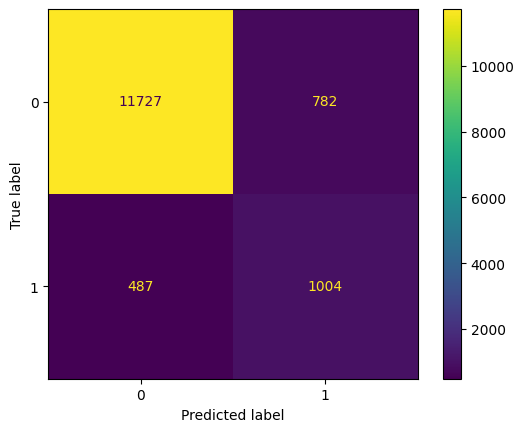

In [122]:
# Plot confusion matrix
cm1 = confusion_matrix(y_test, y_test_lr1_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                              display_labels=lr_model.classes_)
disp1.plot()
plt.show()

In [123]:
# Next predict based on RandomForest model that was trained on non-PCA original 108 features

y_test_rf_pred = rf_model1.predict(X_test_final_scaled)
print(classification_report(y_test, y_test_rf_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12509
           1       0.70      0.70      0.70      1491

    accuracy                           0.94     14000
   macro avg       0.83      0.83      0.83     14000
weighted avg       0.94      0.94      0.94     14000



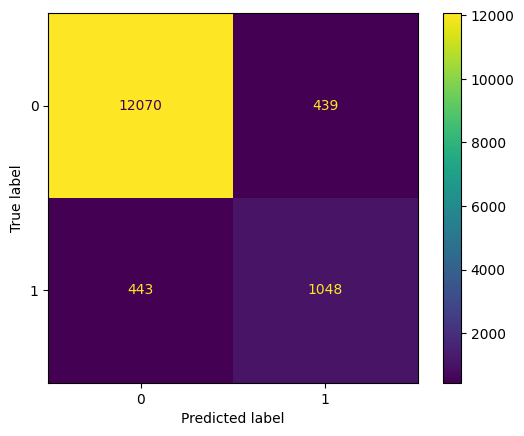

In [124]:
# Plot confusion matrix
cm2 = confusion_matrix(y_test, y_test_rf_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=rf_model1.classes_)
disp2.plot()
plt.show()

In [125]:
# Next predict based on RandomForest model that was trained on PCA components (52)

y_test_rf2_pred = rf_model2.predict(test_pca_components)
print(classification_report(y_test, y_test_rf2_pred))


              precision    recall  f1-score   support

           0       0.95      0.96      0.95     12509
           1       0.63      0.55      0.58      1491

    accuracy                           0.92     14000
   macro avg       0.79      0.75      0.77     14000
weighted avg       0.91      0.92      0.91     14000



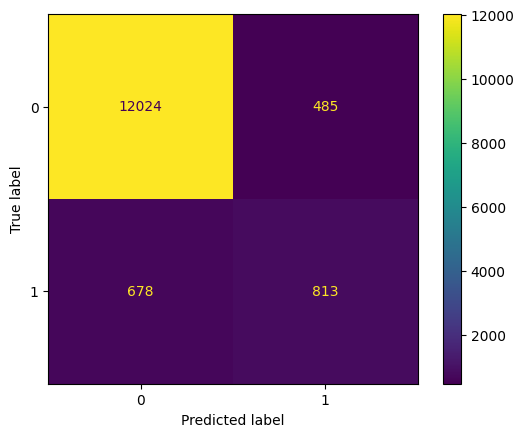

In [126]:
# Plot confusion matrix
cm3 = confusion_matrix(y_test, y_test_rf2_pred)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,
                              display_labels=rf_model2.classes_)
disp3.plot()
plt.show()

In [127]:
# Next predict based on the Hyperparameter tuned RandomForest model that was trained on PCA components (52)

y_test_rf3_pred = rf_best.predict(test_pca_components)
print(classification_report(y_test, y_test_rf3_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12509
           1       0.64      0.55      0.59      1491

    accuracy                           0.92     14000
   macro avg       0.79      0.76      0.77     14000
weighted avg       0.91      0.92      0.92     14000



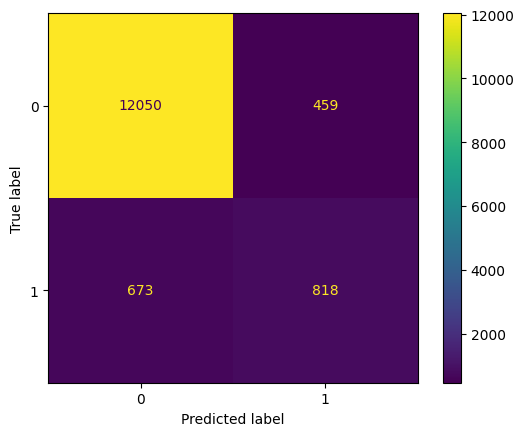

In [128]:
# Plot confusion matrix
cm4 = confusion_matrix(y_test, y_test_rf3_pred)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4,
                              display_labels=rf_best.classes_)
disp4.plot()
plt.show()

In [129]:
# Next predict based on the Hyperparameter tuned RandomForest model that was trained on original 108 features

y_test_rf4_pred = rf_best2.predict(X_test_final_scaled)
print(classification_report(y_test, y_test_rf4_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12509
           1       0.72      0.69      0.70      1491

    accuracy                           0.94     14000
   macro avg       0.84      0.83      0.84     14000
weighted avg       0.94      0.94      0.94     14000



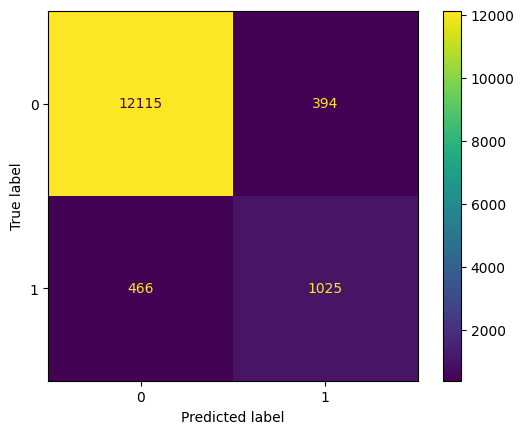

In [130]:
# Plot confusion matrix
cm5 = confusion_matrix(y_test, y_test_rf4_pred)
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5,
                              display_labels=rf_best2.classes_)
disp5.plot()
plt.show()

In [131]:
# Next set predict based on the Hyperparameter tuned Logistic Regression model with PCA components (52)

y_test_lr_tuned = lr_best.predict(test_pca_components)
print(classification_report(y_test, y_test_lr_tuned))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12509
           1       0.56      0.67      0.61      1491

    accuracy                           0.91     14000
   macro avg       0.76      0.81      0.78     14000
weighted avg       0.92      0.91      0.91     14000



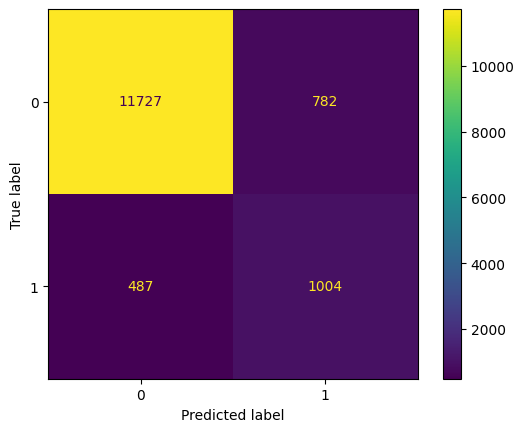

In [132]:
# Plot confusion matrix
cm6 = confusion_matrix(y_test, y_test_lr_tuned)
disp6 = ConfusionMatrixDisplay(confusion_matrix=cm6,
                              display_labels=lr_best.classes_)
disp6.plot()
plt.show()

In [133]:
# Next predict based on the Ensemble model using XGBoostClassifier on the original non-PCA features (108)

y_test_xgb = xgb_model.predict(X_test_final_scaled)
print(classification_report(y_test, y_test_xgb))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12509
           1       0.74      0.65      0.70      1491

    accuracy                           0.94     14000
   macro avg       0.85      0.81      0.83     14000
weighted avg       0.94      0.94      0.94     14000



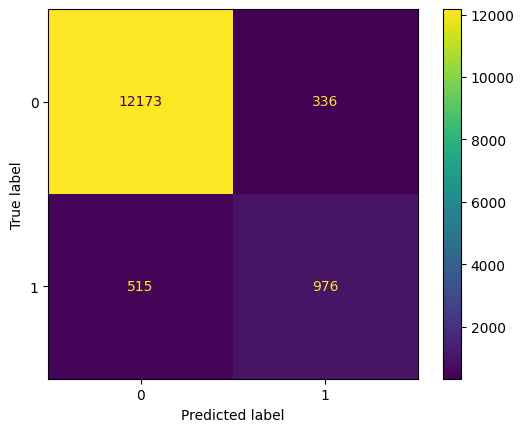

In [134]:
# Plot confusion matrix
cm7 = confusion_matrix(y_test, y_test_xgb)
disp7 = ConfusionMatrixDisplay(confusion_matrix=cm7,
                              display_labels=xgb_model.classes_)
disp7.plot()
plt.show()

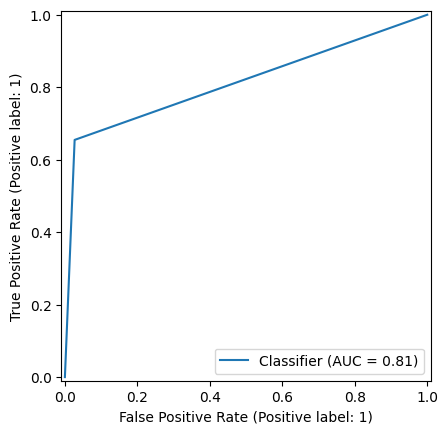

In [135]:
# Plot an ROC Curve

RocCurveDisplay.from_predictions(y_test, y_test_xgb)
plt.show()

In [136]:
# Next predict based on the Ensemble model using RandomForestClassifier on the top 30 non-PCA features

# Refine the X_train and limit it to these 30 features
X_test_top_30_df = pd.DataFrame(X_test_final_scaled, columns=final_columns)
X_test_refined = X_test_top_30_df[top_features]
X_test_refined_array = np.array(X_test_refined)
y_test_rf30_pred = rf30_model.predict(X_test_refined_array)
print(classification_report(y_test, y_test_rf30_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12509
           1       0.68      0.72      0.70      1491

    accuracy                           0.93     14000
   macro avg       0.82      0.84      0.83     14000
weighted avg       0.94      0.93      0.93     14000



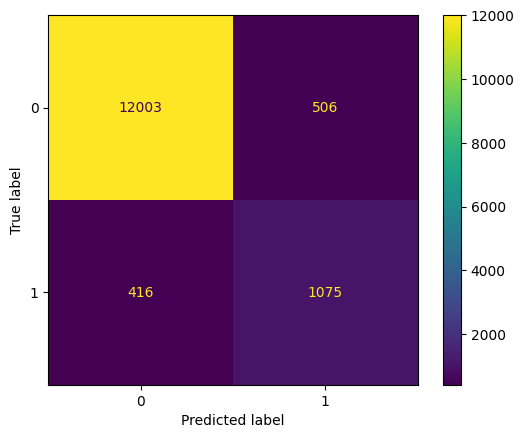

In [137]:
# Plot confusion matrix
cm8 = confusion_matrix(y_test, y_test_rf30_pred)
disp8 = ConfusionMatrixDisplay(confusion_matrix=cm8,
                              display_labels=rf30_model.classes_)
disp8.plot()
plt.show()

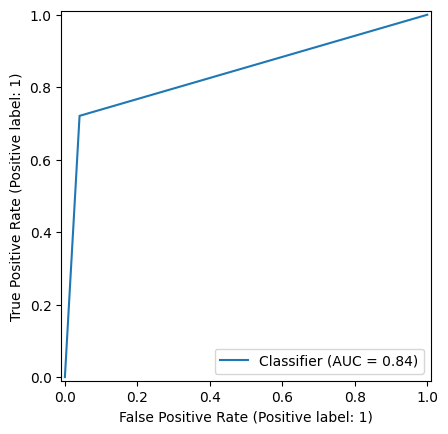

In [138]:
# Plot an ROC Curve

RocCurveDisplay.from_predictions(y_test, y_test_rf30_pred)
plt.show()

In [139]:
# Next predict based on the Ensemble model using Hyperparameter tuned RandomForestClassifier on the top 30 non-PCA features

y_test_rf30_tuned_pred = rf30_model_tuned.predict(X_test_refined_array)
print(classification_report(y_test, y_test_rf30_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12509
           1       0.69      0.70      0.70      1491

    accuracy                           0.94     14000
   macro avg       0.83      0.83      0.83     14000
weighted avg       0.94      0.94      0.94     14000



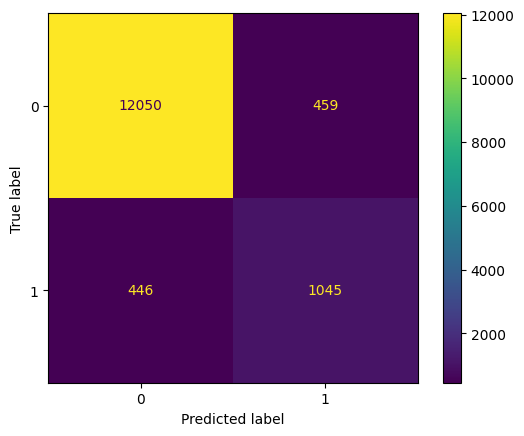

In [141]:
# Plot confusion matrix
cm9 = confusion_matrix(y_test, y_test_rf30_tuned_pred)
disp9 = ConfusionMatrixDisplay(confusion_matrix=cm9,
                              display_labels=rf30_model_tuned.classes_)
disp9.plot()
plt.show()

In [142]:
# Next predict based on the Ensemble model using XGBoostClassifier on the top 30 non-PCA features

y_test_xgb30_tuned_pred = xgb_model_30.predict(X_test_refined_array)
print(classification_report(y_test, y_test_xgb30_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     12509
           1       0.73      0.65      0.69      1491

    accuracy                           0.94     14000
   macro avg       0.84      0.81      0.83     14000
weighted avg       0.93      0.94      0.94     14000



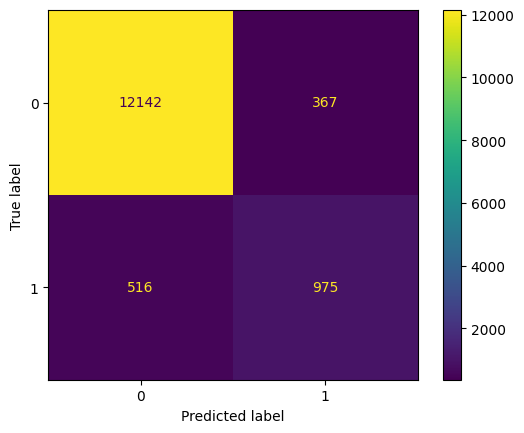

In [143]:
# Plot confusion matrix
cm10 = confusion_matrix(y_test, y_test_xgb30_tuned_pred)
disp10 = ConfusionMatrixDisplay(confusion_matrix=cm10,
                              display_labels=xgb_model_30.classes_)
disp10.plot()
plt.show()

In [144]:
# Next predict based on the initial SVC model on top 30 features

y_test_svc1_pred = svc_model.predict(X_test_refined_array)
print(classification_report(y_test, y_test_svc1_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     12509
           1       0.59      0.74      0.65      1491

    accuracy                           0.92     14000
   macro avg       0.78      0.84      0.80     14000
weighted avg       0.93      0.92      0.92     14000



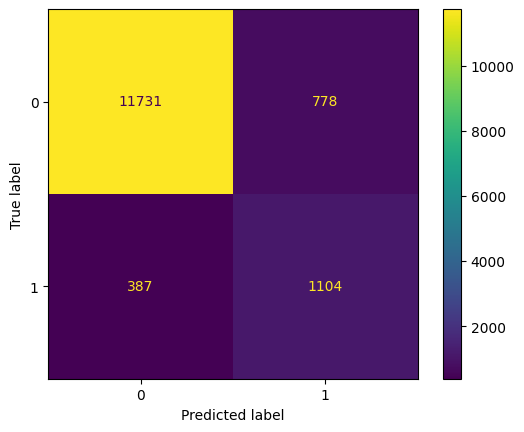

In [145]:
# Plot confusion matrix
cm11 = confusion_matrix(y_test,y_test_svc1_pred)
disp11 = ConfusionMatrixDisplay(confusion_matrix=cm11,
                              display_labels=svc_model.classes_)
disp11.plot()
plt.show()

# 8. Unseen Data Processing, Model Prediction and Submission to Kaggle

In [146]:
submission = unseen.set_index("id")

In [147]:
submission_filtered = submission[new_vars]

In [148]:
# Data Manipulation for unseen dataset in same order as we have done for X_train

submission_filtered = submission[new_vars]
submission_filtered.drop(nonunique_features, axis=1, inplace=True)
submission_filtered[rech_cols] = submission_filtered[rech_cols].apply(lambda x: x.fillna(0))
day_counts(submission_filtered, date_of_last_rech, date_beyond_dataset, 'days_from_last_recharge')
submission_filtered[['days_from_last_recharge']] = submission_filtered[['days_from_last_recharge']].fillna(-1)

# In case of imputation only apply the transform() method to apply value learned during training
submission_filtered[impute_cols] = imp.transform(submission_filtered[impute_cols])

# Process and cap outliers for unseen test data
submission_filtered = submission_filtered.apply(cap_outliers, axis=0)

# Feature engineering for unseen test dataset
submission_filtered['arpu_diff'] = submission_filtered.arpu_8 - ((submission_filtered.arpu_6 + submission_filtered.arpu_7)/2)

submission_filtered['onnet_mou_diff'] = submission_filtered.onnet_mou_8 - ((submission_filtered.onnet_mou_6 + submission_filtered.onnet_mou_7)/2)

submission_filtered['offnet_mou_diff'] = submission_filtered.offnet_mou_8 - ((submission_filtered.offnet_mou_6 + submission_filtered.offnet_mou_7)/2)

submission_filtered['roam_ic_mou_diff'] = submission_filtered.roam_ic_mou_8 - ((submission_filtered.roam_ic_mou_6 + submission_filtered.roam_ic_mou_7)/2)

submission_filtered['roam_og_mou_diff'] = submission_filtered.roam_og_mou_8 - ((submission_filtered.roam_og_mou_6 + submission_filtered.roam_og_mou_7)/2)

submission_filtered['loc_og_mou_diff'] = submission_filtered.loc_og_mou_8 - ((submission_filtered.loc_og_mou_6 + submission_filtered.loc_og_mou_7)/2)

submission_filtered['std_og_mou_diff'] = submission_filtered.std_og_mou_8 - ((submission_filtered.std_og_mou_6 + submission_filtered.std_og_mou_7)/2)

submission_filtered['isd_og_mou_diff'] = submission_filtered.isd_og_mou_8 - ((submission_filtered.isd_og_mou_6 + submission_filtered.isd_og_mou_7)/2)

submission_filtered['spl_og_mou_diff'] = submission_filtered.spl_og_mou_8 - ((submission_filtered.spl_og_mou_6 + submission_filtered.spl_og_mou_7)/2)

submission_filtered['og_others_diff'] = submission_filtered.og_others_8 - ((submission_filtered.og_others_6 + submission_filtered.og_others_7)/2)

submission_filtered['total_og_mou_diff'] = submission_filtered.total_og_mou_8 - ((submission_filtered.total_og_mou_6 + submission_filtered.total_og_mou_7)/2)

submission_filtered['loc_ic_mou_diff'] = submission_filtered.loc_ic_mou_8 - ((submission_filtered.loc_ic_mou_6 + submission_filtered.loc_ic_mou_7)/2)

submission_filtered['std_ic_mou_diff'] = submission_filtered.std_ic_mou_8 - ((submission_filtered.std_ic_mou_6 + submission_filtered.std_ic_mou_7)/2)

submission_filtered['isd_ic_mou_diff'] = submission_filtered.isd_ic_mou_8 - ((submission_filtered.isd_ic_mou_6 + submission_filtered.isd_ic_mou_7)/2)

submission_filtered['spl_ic_mou_diff'] = submission_filtered.spl_ic_mou_8 - ((submission_filtered.spl_ic_mou_6 + submission_filtered.spl_ic_mou_7)/2)

submission_filtered['ic_others_diff'] = submission_filtered.ic_others_8 - ((submission_filtered.ic_others_6 + submission_filtered.ic_others_7)/2)

submission_filtered['total_ic_mou_diff'] = submission_filtered.total_ic_mou_8 - ((submission_filtered.total_ic_mou_6 + submission_filtered.total_ic_mou_7)/2)

submission_filtered['total_rech_num_diff'] = submission_filtered.total_rech_num_8 - ((submission_filtered.total_rech_num_6 + submission_filtered.total_rech_num_7)/2)

submission_filtered['total_rech_amt_diff'] = submission_filtered.total_rech_amt_8 - ((submission_filtered.total_rech_amt_6 + submission_filtered.total_rech_amt_7)/2)

submission_filtered['max_rech_amt_diff'] = submission_filtered.max_rech_amt_8 - ((submission_filtered.max_rech_amt_6 + submission_filtered.max_rech_amt_7)/2)

submission_filtered['vol_2g_mb_diff'] = submission_filtered.vol_2g_mb_8 - ((submission_filtered.vol_2g_mb_6 + submission_filtered.vol_2g_mb_7)/2)

submission_filtered['vol_3g_mb_diff'] = submission_filtered.vol_3g_mb_8 - ((submission_filtered.vol_3g_mb_6 + submission_filtered.vol_3g_mb_7)/2)

submission_filtered.drop(columns_to_del, axis=1, inplace = True)

# Perform scaling for unseen test dataset and again apply only transform method
submission_final_scaled = scale.transform(submission_filtered)

# Create test PCA components by using the transform method
submission_pca_components = pca2.fit_transform(submission_final_scaled)

In [149]:
# Predict the churn based on the RandomForestClassifier model that was trained on top 30 features.
# This model had the best Recall Score on test data and "Recall" or sensitivity for churn cases is a very important metric for Churn cases. 
# It also reduced number of False negatives

submission_top_30_df = pd.DataFrame(submission_final_scaled, columns=final_columns)
submission_refined = submission_top_30_df[top_features]
submission_refined_array = np.array(submission_refined)
unseen['churn_probability'] = rf30_model.predict(submission_refined)

In [150]:
output = unseen[['id','churn_probability']]
output.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  1
3  70002                  0
4  70003                  0

In [151]:
output.to_csv('submission_14Jan25_9.csv',index=False)

# 9. Conclusion

`We will conclude this exercise summarizing the important learnings around` 
- Important variables or "Feature Importances" that are relevant for the Churn prediction
- Evaluation metrics that were important for this Model building and factor in the best model
- Best model chosen
- Important insights for business

## 9.1 Feature Importances

In [166]:
feat_imp_df = pd.DataFrame({'Important_Variables':top_features, 'Importance_Percent':(100 * rf30_model.feature_importances_).round(2)})
feat_imp_df.sort_values(by="Importance_Percent", ascending=False)

Important_Variables  Importance_Percent
0            total_ic_mou_8               24.09
2              loc_ic_mou_8               13.03
1            total_og_mou_8               12.47
7              loc_og_mou_8                6.65
5                    arpu_8                5.07
11            roam_og_mou_8                4.83
4          total_rech_amt_8                4.09
14  days_from_last_recharge                3.73
9             roam_ic_mou_8                2.87
6        last_day_rch_amt_8                2.70
12           max_rech_amt_8                2.63
25              vol_2g_mb_8                2.15
15         roam_og_mou_diff                1.38
3              offnet_mou_8                1.30
10             std_ic_mou_8                1.19
13         total_rech_num_8                1.15
23        total_ic_mou_diff                1.14
17                arpu_diff                1.14
21           total_og_mou_7                0.97
16          loc_ic_mou_diff                0.84
18      total_rech_amt_diff                0.80
26                   arpu_7                0.78
19        max_rech_amt_diff                0.74
22         roam_ic_mou_diff                0.72
29          std_og_mou_diff                0.71
24             loc_ic_mou_7                0.69
27          std_ic_mou_diff                0.64
20           total_ic_mou_7                0.61
28          loc_og_mou_diff                0.49
8               onnet_mou_8                0.39

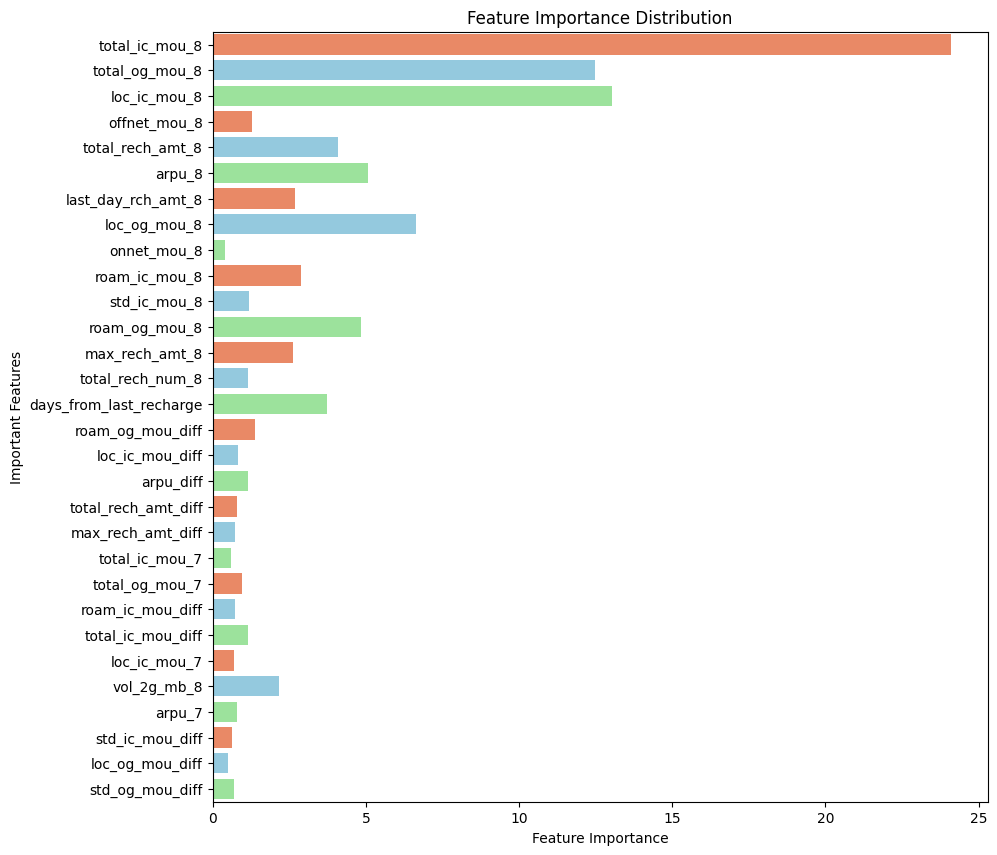

In [167]:
# Lets plot them
plt.figure(figsize=(10, 10))
sns.barplot(y=feat_imp_df['Important_Variables'], x=feat_imp_df['Importance_Percent'], palette=['coral', 'skyblue', 'lightgreen'], orient='h')
plt.xlabel("Feature Importance")
plt.ylabel("Important Features")
plt.title("Feature Importance Distribution")
plt.show()

## 9.2 Evaluation Metrics and Best Model

In case of Churn prediction, the most critical metrics depend on the business impact of false positives (predicting a customer will churn when they won’t) and false negatives (failing to predict a customer will churn when they will). However, in most churn prediction scenarios, Recall and F1 Score are usually more critical than Accuracy or Precision. Failing to identify churners (false negatives) means losing potentially high-value customers who could have been retained with proactive interventions (e.g., discounts or improved service). F1 is also critical if business is concerned about a balance between reducing false positives and false negatives (e.g. when they have limited retention budget). So we have looked into models which have given reasonable good "Recall" and a higher F1 score which aims to strike the balance between precision and recall. So it will also help marketing or retention team not to waste resources on false positives (i.e. customers predicted to churn but don’t actually churn)

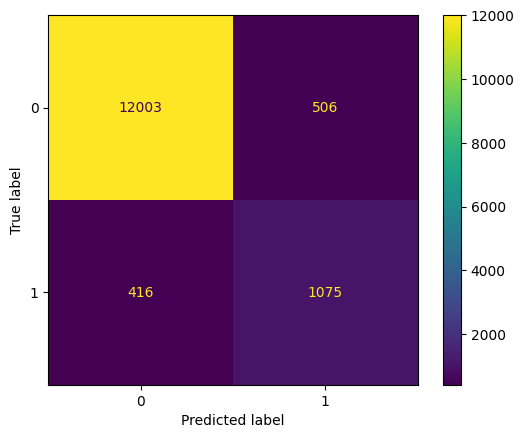

In [168]:
# Get the confusion matrix for the RandomForestClassifier model that was trained on top 30 features
cm = confusion_matrix(y_test, y_test_rf30_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf30_model.classes_)
disp.plot()
plt.show()

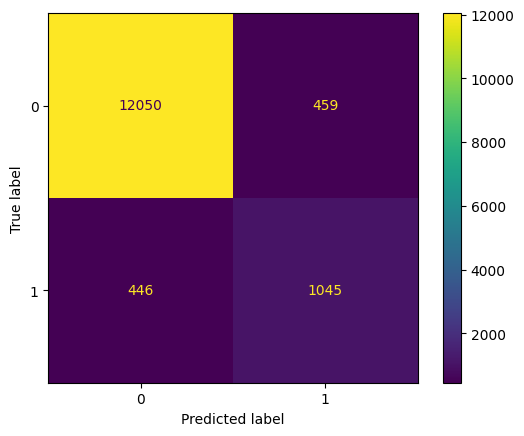

In [169]:
# Get the confusion matrix for the Hyperparameter tuned RandomForestClassifier model that was trained on top 30 features
cm = confusion_matrix(y_test, y_test_rf30_tuned_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf30_model_tuned.classes_)
disp.plot()
plt.show()

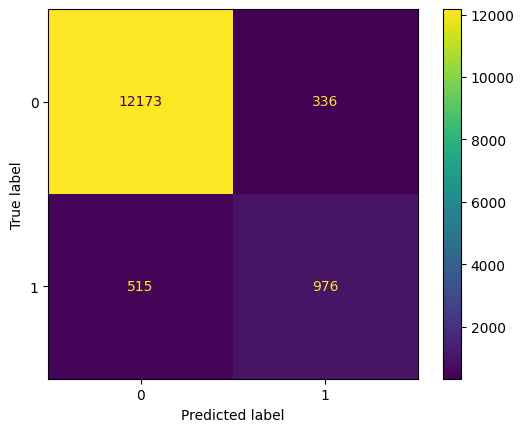

In [170]:
# Also plot the confusion matrix from the XGBoostClassifier model
cm = confusion_matrix(y_test, y_test_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_model.classes_)
disp.plot()
plt.show()

The base RandomForestClassifier model `rf30_Model` predicted more Churn numbers i.e. its "Recall" is higher and it had reduced "False negatives" i.e customers who churned but were incorrectly predicted as churn, among all the models. So is a better fit for predicting "Churn" customers.

## 9.3 Important Insights for Business

`Based on feature importances and EDA performed, its evident that customers who churn has following characteristics :`
- Maximum churn happens in first 6 months hence such customers should be focused for retention purposes
- Customers usage of incoming and outgoing reduces before churn and ARPU decreases
- Customer stop recharging before they churn (Last day of recharge increases)
- Roaming usage is important for customers and some special schemes should be devised so that customers who roam don't churn because of high usage
  